# ANL488 Portfolio Optimisation Project

Hybrid ML framework for portfolio optimisation — 10 US stocks across 5 sectors.

## 1. Setup & Imports

In [1]:
!pip install numpy pandas yfinance matplotlib scikit-learn statsmodels ta

In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, silhouette_score
from ta.momentum import RSIIndicator
from ta.trend import CCIIndicator, MACD

## 2. Configuration

In [5]:
# ========= Portfolio & global settings =========

industry_groups = {
    "Tech (AI Hyperscalers)": ["MSFT", "AMZN"],
    "Energy": ["XOM", "NEE"],
    "Commodities \u2013 Gold & Rare Earths": ["MP", "GLD"],
    "Healthcare": ["NVO", "PFE"],
    "Semiconductors": ["NVDA", "TSM"],
}

index_ticker = "^GSPC"  # S&P 500 (market index)

start_date = "2000-01-01"
end_date   = "2025-12-31"

# Raw (unscaled) market features (shared across horizons)
price_cols = ["Open", "High", "Low", "Close", "Volume", "Index_Close"]

# MACD parameters scaled proportionally to each horizon
macd_params = {
    "weekly":  {"fast": 5,  "slow": 10,  "signal": 4},
    "monthly": {"fast": 12, "slow": 26,  "signal": 9},   # standard
    "yearly":  {"fast": 63, "slow": 126, "signal": 45},
}

# Technical indicators for each horizon
weekly_indicator_cols  = ["RSI_10", "WMA_10", "CCI_10", "Volatility_10", "MACD_10"]
monthly_indicator_cols = ["RSI_42", "WMA_42", "CCI_42", "Volatility_42", "MACD_42"]
yearly_indicator_cols  = ["RSI_1260", "WMA_1260", "CCI_1260", "Volatility_1260", "MACD_1260"]

## 3. Data Functions

In [6]:
# ========= Helper: weighted moving average =========

def weighted_moving_average(series, window):
    weights = np.arange(1, window + 1)
    return series.rolling(window).apply(
        lambda x: np.dot(x, weights) / weights.sum(), raw=True
    )

# ========= In-memory download cache =========

_data_cache = {}

def clear_cache():
    """Clear the in-memory yfinance download cache."""
    _data_cache.clear()

# ========= Data fetching =========

def fetch_data(ticker, start=start_date, end=end_date):
    """Download OHLCV data for a single stock (cached)."""
    key = ("stock", ticker, start, end)
    if key in _data_cache:
        return _data_cache[key].copy()
    df = yf.download(ticker, start=start, end=end)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.droplevel(1)
    df["Ticker"] = ticker
    _data_cache[key] = df
    return df.copy()

def fetch_index_data(ticker=index_ticker, start=start_date, end=end_date):
    """Download index close data (e.g. S&P 500) (cached)."""
    key = ("index", ticker, start, end)
    if key in _data_cache:
        return _data_cache[key].copy()
    idx = yf.download(ticker, start=start, end=end)
    if isinstance(idx.columns, pd.MultiIndex):
        idx.columns = idx.columns.droplevel(1)
    idx = idx.rename(columns={"Close": "Index_Close"})
    idx = idx[["Index_Close"]]
    _data_cache[key] = idx
    return idx.copy()

## 4. Feature Engineering

In [7]:
# ========= Weekly technical indicators (10-day window) =========

def add_weekly_features(df):
    df = df.copy()
    df[["Open", "High", "Low", "Close", "Volume"]] = df[
        ["Open", "High", "Low", "Close", "Volume"]
    ].astype(float)

    df["WMA_10"] = weighted_moving_average(df["Close"], 10)
    df["RSI_10"] = RSIIndicator(close=df["Close"], window=10).rsi()
    df["CCI_10"] = CCIIndicator(
        high=df["High"], low=df["Low"], close=df["Close"], window=10
    ).cci()

    if "Daily_Return" not in df.columns:
        df["Daily_Return"] = df["Close"].pct_change()
    df["Volatility_10"] = df["Daily_Return"].rolling(window=10).std()

    p = macd_params["weekly"]
    macd = MACD(close=df["Close"], window_fast=p["fast"],
                window_slow=p["slow"], window_sign=p["signal"])
    df["MACD_10"] = macd.macd_diff()
    return df


# ========= Monthly technical indicators (42-day window) =========

def add_monthly_features(df):
    df = df.copy()
    df[["Open", "High", "Low", "Close", "Volume"]] = df[
        ["Open", "High", "Low", "Close", "Volume"]
    ].astype(float)

    df["WMA_42"] = weighted_moving_average(df["Close"], 42)
    df["RSI_42"] = RSIIndicator(close=df["Close"], window=42).rsi()
    df["CCI_42"] = CCIIndicator(
        high=df["High"], low=df["Low"], close=df["Close"], window=42
    ).cci()

    if "Daily_Return" not in df.columns:
        df["Daily_Return"] = df["Close"].pct_change()
    df["Volatility_42"] = df["Daily_Return"].rolling(window=42).std()

    p = macd_params["monthly"]
    macd = MACD(close=df["Close"], window_fast=p["fast"],
                window_slow=p["slow"], window_sign=p["signal"])
    df["MACD_42"] = macd.macd_diff()
    return df


# ========= Yearly technical indicators (1260-day window) =========

def add_yearly_features(df):
    df = df.copy()
    df[["Open", "High", "Low", "Close", "Volume"]] = df[
        ["Open", "High", "Low", "Close", "Volume"]
    ].astype(float)

    window_long = 1260

    df["WMA_1260"] = weighted_moving_average(df["Close"], window_long)
    df["RSI_1260"] = RSIIndicator(close=df["Close"], window=window_long).rsi()
    df["CCI_1260"] = CCIIndicator(
        high=df["High"], low=df["Low"], close=df["Close"], window=window_long
    ).cci()

    if "Daily_Return" not in df.columns:
        df["Daily_Return"] = df["Close"].pct_change()
    df["Volatility_1260"] = df["Daily_Return"].rolling(window=window_long).std()

    p = macd_params["yearly"]
    macd = MACD(close=df["Close"], window_fast=p["fast"],
                window_slow=p["slow"], window_sign=p["signal"])
    df["MACD_1260"] = macd.macd_diff()
    return df

In [8]:
# ========= Return labels =========

def add_weekly_return_label(df):
    """Weekly_Return = % return over next 5 trading days."""
    df = df.copy()
    df["Weekly_Return"] = df["Close"].shift(-5) / df["Close"] - 1
    return df

def add_monthly_return_label(df):
    """Monthly_Return = % return over next 21 trading days."""
    df = df.copy()
    df["Monthly_Return"] = df["Close"].shift(-21) / df["Close"] - 1
    return df

def add_yearly_return_label(df):
    """Yearly_Return = % return over next 252 trading days."""
    df = df.copy()
    df["Yearly_Return"] = df["Close"].shift(-252) / df["Close"] - 1
    return df


# ========= Main feature pipeline =========

def build_feature_df(horizon="monthly"):
    """
    Build a single DataFrame for a given horizon with:
      - raw price_cols
      - horizon-specific indicators
      - horizon-specific return label
      - Ticker, Industry, Date
    """
    index_df = fetch_index_data()
    all_rows = []

    if horizon == "weekly":
        feature_fn, label_fn = add_weekly_features, add_weekly_return_label
        ind_cols, target_col = weekly_indicator_cols, "Weekly_Return"
    elif horizon == "monthly":
        feature_fn, label_fn = add_monthly_features, add_monthly_return_label
        ind_cols, target_col = monthly_indicator_cols, "Monthly_Return"
    elif horizon == "yearly":
        feature_fn, label_fn = add_yearly_features, add_yearly_return_label
        ind_cols, target_col = yearly_indicator_cols, "Yearly_Return"
    else:
        raise ValueError("horizon must be 'weekly', 'monthly', or 'yearly'")

    for industry, tickers in industry_groups.items():
        print(f"\n\U0001f4ca [EDA-{horizon}] Processing industry: {industry}")
        for ticker in tickers:
            try:
                print(f"  \u2192 Ticker: {ticker}")
                df = fetch_data(ticker)
                df = df.join(index_df, how="left")
                df = feature_fn(df)
                df = label_fn(df)

                df = df.dropna(
                    subset=price_cols + ind_cols + [target_col]
                ).copy()

                if df.empty:
                    continue

                df["Industry"] = industry
                df["Ticker"]   = ticker
                all_rows.append(df.reset_index())

            except Exception as e:
                print(f"    \u274c Error with {ticker}: {e}")

    if not all_rows:
        return pd.DataFrame()

    full_df = pd.concat(all_rows, ignore_index=True)
    return full_df

## 5. EDA Functions

In [9]:
def raw_nan_report_with_index():
    rows = []
    for industry, tickers in industry_groups.items():
        print(f"\n\U0001f4ca Checking raw NaNs for industry: {industry}")
        for ticker in tickers:
            df_raw = fetch_data(ticker)
            na_counts = df_raw[["Open", "High", "Low", "Close", "Volume"]].isna().sum()
            total_rows = len(df_raw)
            print(f"  \u2192 {ticker}: {total_rows} rows")
            print(f"     NaNs: {na_counts.to_dict()}")
            row = {
                "Ticker": ticker, "Total_Rows": total_rows,
                "NaN_Open": int(na_counts["Open"]), "NaN_High": int(na_counts["High"]),
                "NaN_Low": int(na_counts["Low"]), "NaN_Close": int(na_counts["Close"]),
                "NaN_Volume": int(na_counts["Volume"]), "NaN_Index_Close": np.nan,
            }
            rows.append(row)

    idx_raw = fetch_index_data()
    idx_na = int(idx_raw["Index_Close"].isna().sum())
    idx_total = len(idx_raw)
    print(f"\n\U0001f4ca Checking raw NaNs for index (market):")
    print(f"  \u2192 {index_ticker}: {idx_total} rows")
    print(f"     NaNs in Index_Close: {idx_na}")
    rows.append({
        "Ticker": index_ticker, "Total_Rows": idx_total,
        "NaN_Open": np.nan, "NaN_High": np.nan, "NaN_Low": np.nan,
        "NaN_Close": np.nan, "NaN_Volume": np.nan, "NaN_Index_Close": idx_na,
    })

    return pd.DataFrame(rows).set_index("Ticker")


def data_quality_report(df, horizon_name, indicator_cols, target_col):
    print(f"\n==== Data Quality Report \u2013 {horizon_name} ====")
    print("\n.info():")
    print(df.info())
    print("\nMissing values per column:")
    print(df[price_cols + indicator_cols + [target_col]].isna().sum().sort_values(ascending=False))
    print("\nMissing values per ticker:")
    by_ticker = df.groupby("Ticker")[price_cols + indicator_cols + [target_col]].apply(lambda g: g.isna().sum())
    print(by_ticker)


def describe_and_correlate(df, horizon_name, indicator_cols):
    print(f"\n==== Descriptive statistics \u2013 {horizon_name} RAW features ====")
    display(df[price_cols].describe())
    print(f"\n==== Descriptive statistics \u2013 {horizon_name} TECHNICAL indicators ====")
    display(df[indicator_cols].describe())
    print(f"\n==== Correlation matrix \u2013 {horizon_name} TECHNICAL indicators ====")
    display(df[indicator_cols].corr())
    print(f"\n==== Correlation matrix \u2013 {horizon_name} RAW market features ====")
    display(df[price_cols].corr())


def boxplots_for_horizon(df, horizon_name, indicator_cols):
    plt.figure(figsize=(10, 5))
    df[indicator_cols].boxplot()
    plt.title(f"{horizon_name} \u2013 Technical Indicators (All Tickers)")
    plt.ylabel("Indicator value")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 5))
    df[["Open", "High", "Low", "Close"]].boxplot()
    plt.title(f"{horizon_name} \u2013 Raw Prices (All Tickers)")
    plt.ylabel("Price level")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    df[["Volume"]].boxplot()
    plt.title(f"{horizon_name} \u2013 Volume (All Tickers)")
    plt.ylabel("Volume")
    plt.tight_layout()
    plt.show()


def iqr_outlier_summary(df, horizon_name, columns):
    print(f"\n\U0001f4cd Outlier counts for {horizon_name} \u2013 IQR rule:")
    rows = []
    total = len(df)
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
        mask = (df[col] < lower) | (df[col] > upper)
        n_outliers = mask.sum()
        rows.append((col, n_outliers, n_outliers / total))
        print(f"  {col}: {n_outliers} outliers ({n_outliers/total:.2%} of observations)")
    return pd.DataFrame(rows, columns=["Feature", "Num_Outliers", "Outlier_Fraction"])

## 6. Data Extraction & NaN Report

In [10]:
raw_nan_summary = raw_nan_report_with_index()
raw_nan_summary


📊 Checking raw NaNs for industry: Tech (AI Hyperscalers)


[*********************100%***********************]  1 of 1 completed


  → MSFT: 6538 rows
     NaNs: {'Open': 0, 'High': 0, 'Low': 0, 'Close': 0, 'Volume': 0}


[*********************100%***********************]  1 of 1 completed


  → AMZN: 6538 rows
     NaNs: {'Open': 0, 'High': 0, 'Low': 0, 'Close': 0, 'Volume': 0}

📊 Checking raw NaNs for industry: Energy


[*********************100%***********************]  1 of 1 completed


  → XOM: 6538 rows
     NaNs: {'Open': 0, 'High': 0, 'Low': 0, 'Close': 0, 'Volume': 0}


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


  → NEE: 6538 rows
     NaNs: {'Open': 0, 'High': 0, 'Low': 0, 'Close': 0, 'Volume': 0}

📊 Checking raw NaNs for industry: Commodities – Gold & Rare Earths
  → MP: 1389 rows
     NaNs: {'Open': 0, 'High': 0, 'Low': 0, 'Close': 0, 'Volume': 0}


[*********************100%***********************]  1 of 1 completed


  → GLD: 5312 rows
     NaNs: {'Open': 0, 'High': 0, 'Low': 0, 'Close': 0, 'Volume': 0}

📊 Checking raw NaNs for industry: Healthcare


[*********************100%***********************]  1 of 1 completed


  → NVO: 6538 rows
     NaNs: {'Open': 0, 'High': 0, 'Low': 0, 'Close': 0, 'Volume': 0}


[*********************100%***********************]  1 of 1 completed


  → PFE: 6538 rows
     NaNs: {'Open': 0, 'High': 0, 'Low': 0, 'Close': 0, 'Volume': 0}

📊 Checking raw NaNs for industry: Semiconductors


[*********************100%***********************]  1 of 1 completed


  → NVDA: 6538 rows
     NaNs: {'Open': 0, 'High': 0, 'Low': 0, 'Close': 0, 'Volume': 0}


[*********************100%***********************]  1 of 1 completed


  → TSM: 6538 rows
     NaNs: {'Open': 0, 'High': 0, 'Low': 0, 'Close': 0, 'Volume': 0}


[*********************100%***********************]  1 of 1 completed


📊 Checking raw NaNs for index (market):
  → ^GSPC: 6538 rows
     NaNs in Index_Close: 0


Total_Rows  NaN_Open  NaN_High  NaN_Low  NaN_Close  NaN_Volume  \
Ticker                                                                   
MSFT          6538       0.0       0.0      0.0        0.0         0.0   
AMZN          6538       0.0       0.0      0.0        0.0         0.0   
XOM           6538       0.0       0.0      0.0        0.0         0.0   
NEE           6538       0.0       0.0      0.0        0.0         0.0   
MP            1389       0.0       0.0      0.0        0.0         0.0   
GLD           5312       0.0       0.0      0.0        0.0         0.0   
NVO           6538       0.0       0.0      0.0        0.0         0.0   
PFE           6538       0.0       0.0      0.0        0.0         0.0   
NVDA          6538       0.0       0.0      0.0        0.0         0.0   
TSM           6538       0.0       0.0      0.0        0.0         0.0   
^GSPC         6538       NaN       NaN      NaN        NaN         NaN   

        NaN_Index_Close  
Ticker                   
MSFT                NaN  
AMZN                NaN  
XOM                 NaN  
NEE                 NaN  
MP                  NaN  
GLD                 NaN  
NVO                 NaN  
PFE                 NaN  
NVDA                NaN  
TSM                 NaN  
^GSPC               0.0

## 7. Feature Generation

In [11]:
weekly_eda_df  = build_feature_df("weekly")
monthly_eda_df = build_feature_df("monthly")
yearly_eda_df  = build_feature_df("yearly")

print("Weekly EDA shape :", weekly_eda_df.shape)
print("Monthly EDA shape:", monthly_eda_df.shape)
print("Yearly EDA shape :", yearly_eda_df.shape)

print("\nWeekly sample:")
display(weekly_eda_df.head())
print("\nMonthly sample:")
display(monthly_eda_df.head())
print("\nYearly sample:")
display(yearly_eda_df.head())


📊 [EDA-weekly] Processing industry: Tech (AI Hyperscalers)
  → Ticker: MSFT
  → Ticker: AMZN

📊 [EDA-weekly] Processing industry: Energy
  → Ticker: XOM
  → Ticker: NEE

📊 [EDA-weekly] Processing industry: Commodities – Gold & Rare Earths
  → Ticker: MP
  → Ticker: GLD

📊 [EDA-weekly] Processing industry: Healthcare
  → Ticker: NVO
  → Ticker: PFE

📊 [EDA-weekly] Processing industry: Semiconductors
  → Ticker: NVDA
  → Ticker: TSM

📊 [EDA-monthly] Processing industry: Tech (AI Hyperscalers)
  → Ticker: MSFT
  → Ticker: AMZN

📊 [EDA-monthly] Processing industry: Energy
  → Ticker: XOM
  → Ticker: NEE

📊 [EDA-monthly] Processing industry: Commodities – Gold & Rare Earths
  → Ticker: MP
  → Ticker: GLD

📊 [EDA-monthly] Processing industry: Healthcare
  → Ticker: NVO
  → Ticker: PFE

📊 [EDA-monthly] Processing industry: Semiconductors
  → Ticker: NVDA
  → Ticker: TSM

📊 [EDA-yearly] Processing industry: Tech (AI Hyperscalers)
  → Ticker: MSFT
  → Ticker: AMZN

📊 [EDA-yearly] Processing in

Price       Date      Close       High        Low       Open      Volume  \
0     2000-01-20  32.375359  33.501624  32.337180  32.699876  56349800.0   
1     2000-01-21  31.688137  32.757134  31.535423  32.680777  68416200.0   
2     2000-01-24  30.924582  32.279918  30.790957  31.702468  63597600.0   
3     2000-01-25  31.401827  31.726344  30.409186  30.848238  59823200.0   
4     2000-01-26  30.351908  31.611798  30.275551  31.287281  49365000.0   

Price Ticker  Index_Close     WMA_10     RSI_10      CCI_10  Daily_Return  \
0       MSFT  1445.569946  33.398894  36.302208  -75.554088     -0.009346   
1       MSFT  1441.359985  33.067086  32.781065 -110.899799     -0.021227   
2       MSFT  1401.530029  32.631157  29.275513 -127.891071     -0.024096   
3       MSFT  1410.030029  32.338573  34.164848 -117.006306      0.015433   
4       MSFT  1404.089966  31.907504  29.226045 -121.711614     -0.033435   

Price  Volatility_10   MACD_10  Weekly_Return                Industry  
0           0.034504 -0.104221      -0.068396  Tech (AI Hyperscalers)  
1           0.033646 -0.160127      -0.053011  Tech (AI Hyperscalers)  
2           0.033442 -0.198522      -0.033333  Tech (AI Hyperscalers)  
3           0.033978 -0.105197       0.001216  Tech (AI Hyperscalers)  
4           0.034509 -0.125407       0.014466  Tech (AI Hyperscalers)


Monthly sample:


Price       Date      Close       High        Low       Open       Volume  \
0     2000-03-03  29.359261  30.199187  28.672048  28.939297  101435200.0   
1     2000-03-06  27.679420  29.741060  27.526706  29.321096   93609400.0   
2     2000-03-07  28.366621  29.779225  28.080282  29.359262  135061000.0   
3     2000-03-08  29.187473  29.378366  27.793958  28.652974   94290000.0   
4     2000-03-09  30.542799  30.542799  29.015659  29.111105   88198800.0   

Price Ticker  Index_Close     WMA_42     RSI_42      CCI_42  Daily_Return  \
0       MSFT  1409.170044  30.194776  41.606225  -70.329931      0.029451   
1       MSFT  1391.280029  30.030457  38.154052 -107.870310     -0.057217   
2       MSFT  1355.619995  29.905541  40.232228  -87.675276      0.024827   
3       MSFT  1366.699951  29.825887  42.592627  -82.040387      0.028937   
4       MSFT  1401.689941  29.814154  46.187207  -29.547067      0.046435   

Price  Volatility_42   MACD_42  Monthly_Return                Industry  
0           0.028415  0.020202       -0.054617  Tech (AI Hyperscalers)  
1           0.029229  0.002262       -0.022759  Tech (AI Hyperscalers)  
2           0.029493  0.044707       -0.069986  Tech (AI Hyperscalers)  
3           0.029564  0.131202       -0.100066  Tech (AI Hyperscalers)  
4           0.030440  0.274582       -0.109375  Tech (AI Hyperscalers)


Yearly sample:


Price       Date      Close       High        Low       Open      Volume  \
0     2005-01-07  18.372190  18.523742  18.337747  18.475521  68723300.0   
1     2005-01-10  18.461735  18.503068  18.282630  18.323961  70376600.0   
2     2005-01-11  18.413523  18.475521  18.330859  18.385969  64712000.0   
3     2005-01-12  18.447966  18.496186  18.337746  18.441077  72940600.0   
4     2005-01-13  18.096643  18.461744  18.020867  18.379080  89861600.0   

Price Ticker  Index_Close   WMA_1260   RSI_1260  CCI_1260  Daily_Return  \
0       MSFT  1186.189941  17.066207  48.690010  0.284391     -0.002990   
1       MSFT  1190.250000  17.066318  48.710134  0.731827      0.004874   
2       MSFT  1182.989990  17.066373  48.699842  0.829432     -0.002611   
3       MSFT  1187.699951  17.066503  48.707590  1.677182      0.001871   
4       MSFT  1177.449951  17.066096  48.632606 -4.033587     -0.019044   

Price  Volatility_1260  MACD_1260  Yearly_Return                Industry  
0             0.025311   0.049077       0.019421  Tech (AI Hyperscalers)  
1             0.025294   0.044054       0.019765  Tech (AI Hyperscalers)  
2             0.025292   0.038464       0.033416  Tech (AI Hyperscalers)  
3             0.025275   0.033596       0.025818  Tech (AI Hyperscalers)  
4             0.025278   0.023678       0.047659  Tech (AI Hyperscalers)

## 8. Exploratory Data Analysis

### 8.1 Data Quality Reports

In [12]:
data_quality_report(weekly_eda_df,  "Weekly",  weekly_indicator_cols,  "Weekly_Return")
data_quality_report(monthly_eda_df, "Monthly", monthly_indicator_cols, "Monthly_Return")
data_quality_report(yearly_eda_df,  "Yearly",  yearly_indicator_cols,  "Yearly_Return")


==== Data Quality Report – Weekly ====

.info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58835 entries, 0 to 58834
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           58835 non-null  datetime64[ns]
 1   Close          58835 non-null  float64       
 2   High           58835 non-null  float64       
 3   Low            58835 non-null  float64       
 4   Open           58835 non-null  float64       
 5   Volume         58835 non-null  float64       
 6   Ticker         58835 non-null  object        
 7   Index_Close    58835 non-null  float64       
 8   WMA_10         58835 non-null  float64       
 9   RSI_10         58835 non-null  float64       
 10  CCI_10         58835 non-null  float64       
 11  Daily_Return   58835 non-null  float64       
 12  Volatility_10  58835 non-null  float64       
 13  MACD_10        58835 non-null  float64       
 14  Weekly_Return  58835

### 8.2 Descriptive Statistics & Correlations

In [13]:
describe_and_correlate(weekly_eda_df,  "Weekly",  weekly_indicator_cols)
describe_and_correlate(monthly_eda_df, "Monthly", monthly_indicator_cols)
describe_and_correlate(yearly_eda_df,  "Yearly",  yearly_indicator_cols)


==== Descriptive statistics – Weekly RAW features ====


Price          Open          High           Low         Close        Volume  \
count  58835.000000  58835.000000  58835.000000  58835.000000  5.883500e+04   
mean      47.971639     48.413776     47.503151     47.970515  9.373425e+07   
std       69.052565     69.615011     68.434037     69.046856  2.334974e+08   
min        0.055774      0.060206      0.055010      0.056309  6.000000e+02   
25%        6.860718      6.966834      6.751457      6.857381  7.265550e+06   
50%       20.374747     20.559566     20.188552     20.372744  1.662820e+07   
75%       57.115623     57.561155     56.667505     57.137728  5.507700e+07   
max      553.283183    553.502444    539.759814    541.057373  9.230856e+09   

Price   Index_Close  
count  58835.000000  
mean    2347.036535  
std     1490.408096  
min      676.530029  
25%     1226.500000  
50%     1667.469971  
75%     3037.560059  
max     6901.000000


==== Descriptive statistics – Weekly TECHNICAL indicators ====


Price        RSI_10        WMA_10        CCI_10  Volatility_10       MACD_10
count  58835.000000  58835.000000  58835.000000   58835.000000  58835.000000
mean      52.858863     47.880658     12.595653       0.018907     -0.000076
std       13.939384     68.876840    104.334777       0.014388      0.237647
min        8.247957      0.060922   -333.333333       0.002030     -3.195162
25%       43.102093      6.832924    -72.787867       0.010020     -0.030462
50%       53.058641     20.334243     22.705245       0.014766     -0.000002
75%       62.868929     57.090815     95.721938       0.022749      0.032050
max       96.265821    528.383988    333.333333       0.199159      3.992439


==== Correlation matrix – Weekly TECHNICAL indicators ====


Price            RSI_10    WMA_10    CCI_10  Volatility_10   MACD_10
Price                                                               
RSI_10         1.000000  0.038693  0.807553      -0.099230  0.250059
WMA_10         0.038693  1.000000  0.017941      -0.166877 -0.018507
CCI_10         0.807553  0.017941  1.000000      -0.037619  0.412063
Volatility_10 -0.099230 -0.166877 -0.037619       1.000000  0.022156
MACD_10        0.250059 -0.018507  0.412063       0.022156  1.000000


==== Correlation matrix – Weekly RAW market features ====


Price            Open      High       Low     Close    Volume  Index_Close
Price                                                                     
Open         1.000000  0.999940  0.999931  0.999878 -0.179064     0.622831
High         0.999940  1.000000  0.999896  0.999935 -0.178752     0.624034
Low          0.999931  0.999896  1.000000  0.999940 -0.179511     0.621545
Close        0.999878  0.999935  0.999940  1.000000 -0.179110     0.622778
Volume      -0.179064 -0.178752 -0.179511 -0.179110  1.000000    -0.114015
Index_Close  0.622831  0.624034  0.621545  0.622778 -0.114015     1.000000


==== Descriptive statistics – Monthly RAW features ====


Price          Open          High           Low         Close        Volume  \
count  58375.000000  58375.000000  58375.000000  58375.000000  5.837500e+04   
mean      47.757928     48.198183     47.292330     47.757636  9.400328e+07   
std       68.427166     68.986058     67.812964     68.421891  2.341046e+08   
min        0.055774      0.060206      0.055010      0.056309  2.600000e+04   
25%        6.863719      6.973427      6.755584      6.863830  7.283900e+06   
50%       20.383870     20.569732     20.196431     20.378571  1.670500e+07   
75%       57.095342     57.538747     56.650859     57.117498  5.512640e+07   
max      553.283183    553.502444    539.759814    541.057373  9.230856e+09   

Price   Index_Close  
count  58375.000000  
mean    2338.771280  
std     1476.036072  
min      676.530029  
25%     1224.510010  
50%     1676.260010  
75%     3014.300049  
max     6890.890137


==== Descriptive statistics – Monthly TECHNICAL indicators ====


Price        RSI_42        WMA_42        CCI_42  Volatility_42       MACD_42
count  58375.000000  58375.000000  58375.000000   58375.000000  58375.000000
mean      52.574005     47.340500     24.089103       0.019749     -0.000509
std        6.913669     67.639129    112.548957       0.012937      0.426502
min       25.960542      0.068625   -795.490444       0.003473     -4.582752
25%       47.818572      6.730320    -61.669831       0.011460     -0.053778
50%       52.395874     20.250902     37.096607       0.016085      0.000502
75%       57.275206     56.695854    108.002825       0.023382      0.060950
max       84.984347    518.677350    690.300273       0.120178      7.351363


==== Correlation matrix – Monthly TECHNICAL indicators ====


Price            RSI_42    WMA_42    CCI_42  Volatility_42   MACD_42
Price                                                               
RSI_42         1.000000  0.064801  0.813542      -0.174956  0.174107
WMA_42         0.064801  1.000000  0.018148      -0.195405 -0.042493
CCI_42         0.813542  0.018148  1.000000      -0.083647  0.337401
Volatility_42 -0.174956 -0.195405 -0.083647       1.000000  0.019461
MACD_42        0.174107 -0.042493  0.337401       0.019461  1.000000


==== Correlation matrix – Monthly RAW market features ====


Price            Open      High       Low     Close    Volume  Index_Close
Price                                                                     
Open         1.000000  0.999939  0.999930  0.999877 -0.180262     0.620891
High         0.999939  1.000000  0.999894  0.999934 -0.179942     0.622112
Low          0.999930  0.999894  1.000000  0.999939 -0.180720     0.619607
Close        0.999877  0.999934  0.999939  1.000000 -0.180310     0.620861
Volume      -0.180262 -0.179942 -0.180720 -0.180310  1.000000    -0.113807
Index_Close  0.620891  0.622112  0.619607  0.620861 -0.113807     1.000000


==== Descriptive statistics – Yearly RAW features ====


Price          Open          High           Low         Close        Volume  \
count  44008.000000  44008.000000  44008.000000  44008.000000  4.400800e+04   
mean      50.245358     50.682934     49.787394     50.248134  8.891651e+07   
std       64.128631     64.651217     63.566037     64.127935  2.011990e+08   
min        0.137525      0.146235      0.131795      0.135233  1.920000e+05   
25%        9.098019      9.186249      9.001405      9.093703  7.921759e+06   
50%       23.774033     23.978204     23.571089     23.769332  1.896370e+07   
75%       62.261432     62.705615     61.735018     62.298820  5.475914e+07   
max      461.821761    463.156829    459.309990    462.375580  3.692928e+09   

Price   Index_Close  
count  44008.000000  
mean    2383.993219  
std     1277.287503  
min      676.530029  
25%     1321.969971  
50%     2022.550049  
75%     3078.270020  
max     6090.270020


==== Descriptive statistics – Yearly TECHNICAL indicators ====


Price      RSI_1260      WMA_1260      CCI_1260  Volatility_1260     MACD_1260
count  44008.000000  44008.000000  44008.000000     44008.000000  44008.000000
mean      52.126341     40.306892    109.495692         0.019159      0.017201
std        1.925430     50.382142    105.710634         0.007763      0.754541
min       47.766144      0.175813   -671.141404         0.007747     -6.265026
25%       50.657684      7.877479     46.168824         0.014218     -0.119572
50%       51.959097     19.779380    125.350985         0.017514      0.006626
75%       53.443451     53.428841    179.561225         0.021645      0.149491
max       59.770187    328.496932    506.558043         0.056941      6.190865


==== Correlation matrix – Yearly TECHNICAL indicators ====


Price            RSI_1260  WMA_1260  CCI_1260  Volatility_1260  MACD_1260
Price                                                                    
RSI_1260         1.000000  0.091657  0.770842        -0.165587   0.067821
WMA_1260         0.091657  1.000000 -0.044866        -0.338604  -0.012294
CCI_1260         0.770842 -0.044866  1.000000        -0.047520   0.100071
Volatility_1260 -0.165587 -0.338604 -0.047520         1.000000   0.012472
MACD_1260        0.067821 -0.012294  0.100071         0.012472   1.000000


==== Correlation matrix – Yearly RAW market features ====


Price            Open      High       Low     Close    Volume  Index_Close
Price                                                                     
Open         1.000000  0.999942  0.999932  0.999878 -0.214301     0.609215
High         0.999942  1.000000  0.999900  0.999934 -0.213723     0.610182
Low          0.999932  0.999900  1.000000  0.999940 -0.215048     0.608252
Close        0.999878  0.999934  0.999940  1.000000 -0.214366     0.609210
Volume      -0.214301 -0.213723 -0.215048 -0.214366  1.000000    -0.090557
Index_Close  0.609215  0.610182  0.608252  0.609210 -0.090557     1.000000

### 8.3 Boxplots & Outlier Detection

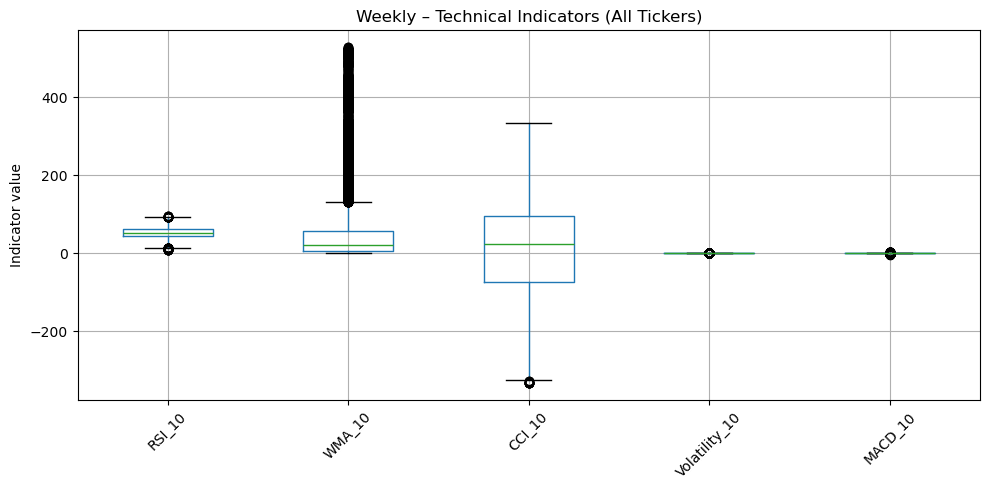

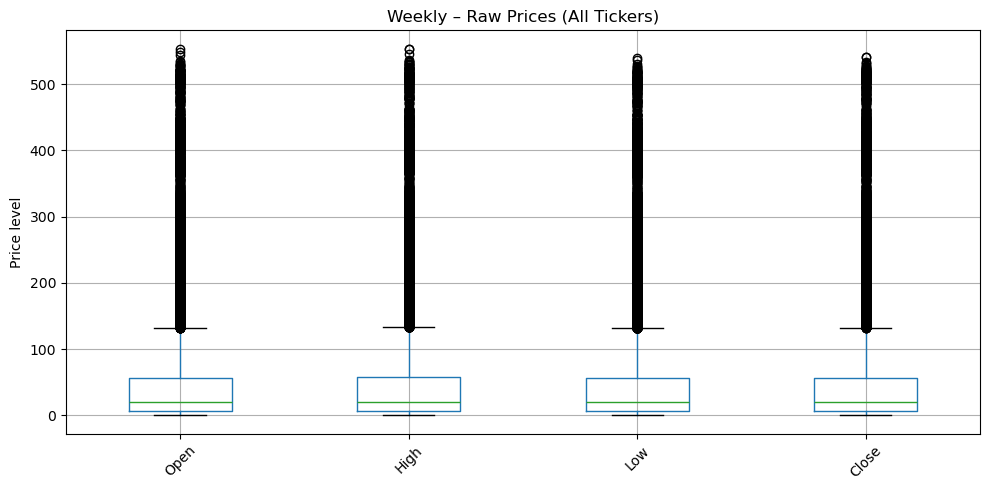

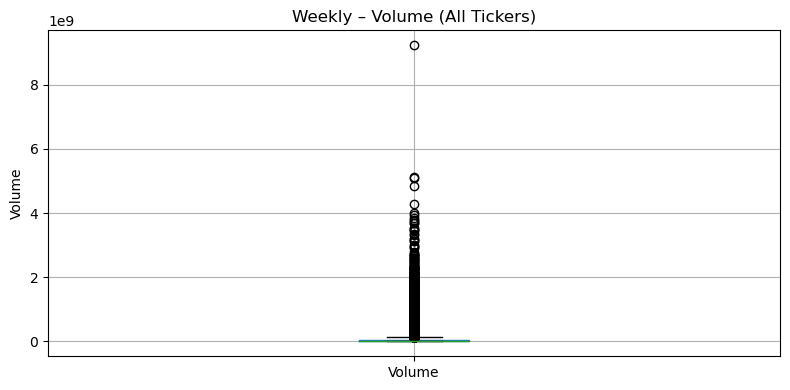

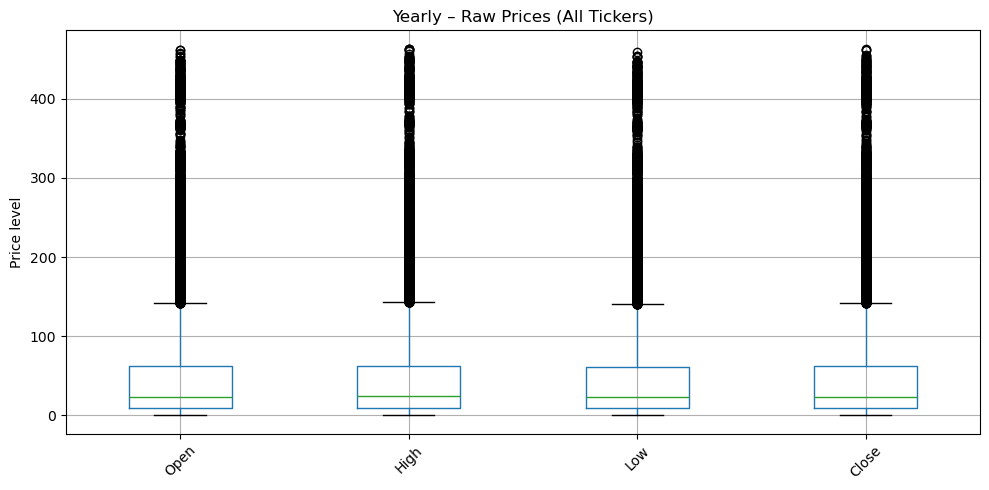

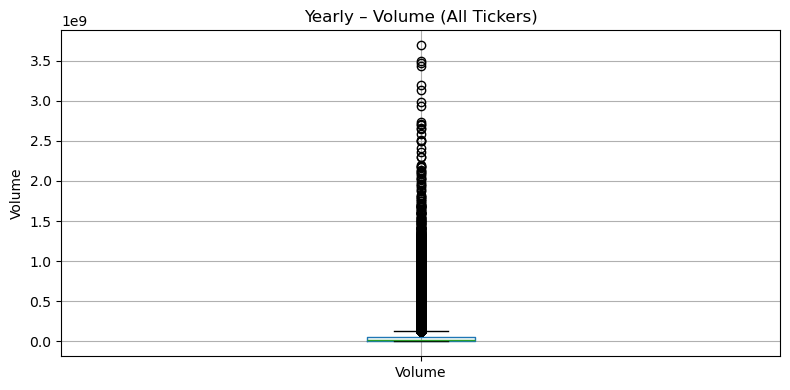


📍 Outlier counts for Weekly RAW – IQR rule:
  Open: 5620 outliers (9.55% of observations)
  High: 5637 outliers (9.58% of observations)
  Low: 5601 outliers (9.52% of observations)
  Close: 5616 outliers (9.55% of observations)
  Volume: 8712 outliers (14.81% of observations)
  Index_Close: 2570 outliers (4.37% of observations)

📍 Outlier counts for Weekly TECH – IQR rule:
  RSI_10: 70 outliers (0.12% of observations)
  WMA_10: 5599 outliers (9.52% of observations)
  CCI_10: 10 outliers (0.02% of observations)
  Volatility_10: 3768 outliers (6.40% of observations)
  MACD_10: 12638 outliers (21.48% of observations)

📍 Outlier counts for Monthly RAW – IQR rule:
  Open: 5543 outliers (9.50% of observations)
  High: 5562 outliers (9.53% of observations)
  Low: 5526 outliers (9.47% of observations)
  Close: 5538 outliers (9.49% of observations)
  Volume: 8645 outliers (14.81% of observations)
  Index_Close: 2580 outliers (4.42% of observations)

📍 Outlier counts for Monthly TECH – IQR rule

Feature  Num_Outliers  Outlier_Fraction
0         Open          5620          0.095521
1         High          5637          0.095810
2          Low          5601          0.095198
3        Close          5616          0.095453
4       Volume          8712          0.148075
5  Index_Close          2570          0.043681

Feature  Num_Outliers  Outlier_Fraction
0         RSI_10            70          0.001190
1         WMA_10          5599          0.095164
2         CCI_10            10          0.000170
3  Volatility_10          3768          0.064044
4        MACD_10         12638          0.214804

Feature  Num_Outliers  Outlier_Fraction
0         Open          5543          0.094955
1         High          5562          0.095281
2          Low          5526          0.094664
3        Close          5538          0.094869
4       Volume          8645          0.148094
5  Index_Close          2580          0.044197

Feature  Num_Outliers  Outlier_Fraction
0         RSI_42           393          0.006732
1         WMA_42          5501          0.094236
2         CCI_42           163          0.002792
3  Volatility_42          3986          0.068283
4        MACD_42         12668          0.217011

Feature  Num_Outliers  Outlier_Fraction
0         Open          3982          0.090484
1         High          3992          0.090711
2          Low          3984          0.090529
3        Close          3979          0.090415
4       Volume          6389          0.145178
5  Index_Close           558          0.012680

Feature  Num_Outliers  Outlier_Fraction
0         RSI_1260           399          0.009067
1         WMA_1260          4412          0.100254
2         CCI_1260           806          0.018315
3  Volatility_1260          3306          0.075123
4        MACD_1260          8777          0.199441

In [14]:
boxplots_for_horizon(weekly_eda_df,  "Weekly",  weekly_indicator_cols)
boxplots_for_horizon(monthly_eda_df, "Monthly", monthly_indicator_cols)
boxplots_for_horizon(yearly_eda_df,  "Yearly",  yearly_indicator_cols)

out_raw_week  = iqr_outlier_summary(weekly_eda_df,  "Weekly RAW",  price_cols)
out_ind_week  = iqr_outlier_summary(weekly_eda_df,  "Weekly TECH", weekly_indicator_cols)
out_raw_month = iqr_outlier_summary(monthly_eda_df, "Monthly RAW",  price_cols)
out_ind_month = iqr_outlier_summary(monthly_eda_df, "Monthly TECH", monthly_indicator_cols)
out_raw_year  = iqr_outlier_summary(yearly_eda_df,  "Yearly RAW",  price_cols)
out_ind_year  = iqr_outlier_summary(yearly_eda_df,  "Yearly TECH", yearly_indicator_cols)

display(out_raw_week)
display(out_ind_week)
display(out_raw_month)
display(out_ind_month)
display(out_raw_year)
display(out_ind_year)

### 8.4 Inter-Stock Return Correlations

In [15]:
weekly_returns_matrix = (
    weekly_eda_df
    .pivot(index="Date", columns="Ticker", values="Weekly_Return")
    .sort_index()
    .dropna(how="any")
)
weekly_stock_corr = weekly_returns_matrix.corr()
print("Weekly return correlation between stocks:")
display(weekly_stock_corr)

Weekly return correlation between stocks:


Ticker      AMZN       GLD        MP      MSFT       NEE      NVDA       NVO  \
Ticker                                                                         
AMZN    1.000000  0.066843  0.198298  0.635607  0.210740  0.551629  0.184623   
GLD     0.066843  1.000000  0.176057  0.107107  0.226148  0.078128  0.101608   
MP      0.198298  0.176057  1.000000  0.167270  0.164124  0.212988  0.098852   
MSFT    0.635607  0.107107  0.167270  1.000000  0.251399  0.637267  0.263920   
NEE     0.210740  0.226148  0.164124  0.251399  1.000000  0.165151  0.223592   
NVDA    0.551629  0.078128  0.212988  0.637267  0.165151  1.000000  0.190740   
NVO     0.184623  0.101608  0.098852  0.263920  0.223592  0.190740  1.000000   
PFE     0.081573  0.048554  0.032139  0.155638  0.280956  0.097195  0.303973   
TSM     0.434740  0.214818  0.271281  0.429888  0.154974  0.633906  0.151888   
XOM     0.027573  0.066075  0.230621 -0.021031  0.128736  0.024581  0.133753   

Ticker       PFE       TSM       XOM  
Ticker                                
AMZN    0.081573  0.434740  0.027573  
GLD     0.048554  0.214818  0.066075  
MP      0.032139  0.271281  0.230621  
MSFT    0.155638  0.429888 -0.021031  
NEE     0.280956  0.154974  0.128736  
NVDA    0.097195  0.633906  0.024581  
NVO     0.303973  0.151888  0.133753  
PFE     1.000000  0.075064  0.080110  
TSM     0.075064  1.000000  0.135589  
XOM     0.080110  0.135589  1.000000

In [16]:
monthly_returns_matrix = (
    monthly_eda_df
    .pivot(index="Date", columns="Ticker", values="Monthly_Return")
    .sort_index()
    .dropna(how="any")
)
monthly_stock_corr = monthly_returns_matrix.corr()

yearly_returns_matrix = (
    yearly_eda_df
    .pivot(index="Date", columns="Ticker", values="Yearly_Return")
    .sort_index()
    .dropna(how="any")
)
yearly_stock_corr = yearly_returns_matrix.corr()

print("Monthly return correlation between stocks:")
display(monthly_stock_corr)
print("\nYearly return correlation between stocks:")
display(yearly_stock_corr)

Monthly return correlation between stocks:


Ticker      AMZN       GLD        MP      MSFT       NEE      NVDA       NVO  \
Ticker                                                                         
AMZN    1.000000  0.063457  0.171567  0.666547  0.235603  0.564219  0.131108   
GLD     0.063457  1.000000  0.043672  0.058806  0.292770  0.054749  0.065887   
MP      0.171567  0.043672  1.000000  0.159229  0.138982  0.169936 -0.137220   
MSFT    0.666547  0.058806  0.159229  1.000000  0.325058  0.712161  0.303120   
NEE     0.235603  0.292770  0.138982  0.325058  1.000000  0.241940  0.205576   
NVDA    0.564219  0.054749  0.169936  0.712161  0.241940  1.000000  0.294261   
NVO     0.131108  0.065887 -0.137220  0.303120  0.205576  0.294261  1.000000   
PFE    -0.033871 -0.038277  0.159624  0.171966  0.405133  0.202742  0.263951   
TSM     0.458155  0.179958  0.271141  0.567918  0.260724  0.656238  0.141107   
XOM    -0.117279 -0.017462  0.279353 -0.162798 -0.097720 -0.099181  0.036474   

Ticker       PFE       TSM       XOM  
Ticker                                
AMZN   -0.033871  0.458155 -0.117279  
GLD    -0.038277  0.179958 -0.017462  
MP      0.159624  0.271141  0.279353  
MSFT    0.171966  0.567918 -0.162798  
NEE     0.405133  0.260724 -0.097720  
NVDA    0.202742  0.656238 -0.099181  
NVO     0.263951  0.141107  0.036474  
PFE     1.000000  0.132409  0.017238  
TSM     0.132409  1.000000  0.011602  
XOM     0.017238  0.011602  1.000000


Yearly return correlation between stocks:


Ticker      AMZN       GLD      MSFT       NEE      NVDA       NVO       PFE  \
Ticker                                                                         
AMZN    1.000000  0.054568  0.421636  0.099616  0.445001  0.049753 -0.003535   
GLD     0.054568  1.000000 -0.033447 -0.026491  0.203565 -0.178724 -0.379158   
MSFT    0.421636 -0.033447  1.000000  0.211370  0.526571  0.176988 -0.137117   
NEE     0.099616 -0.026491  0.211370  1.000000 -0.117110 -0.126771  0.380310   
NVDA    0.445001  0.203565  0.526571 -0.117110  1.000000  0.103353 -0.385151   
NVO     0.049753 -0.178724  0.176988 -0.126771  0.103353  1.000000  0.025456   
PFE    -0.003535 -0.379158 -0.137117  0.380310 -0.385151  0.025456  1.000000   
TSM     0.412435  0.409001  0.449522  0.328381  0.541004  0.017188 -0.154757   
XOM    -0.450819 -0.184966 -0.310071 -0.201861 -0.161011  0.203457  0.322482   

Ticker       TSM       XOM  
Ticker                      
AMZN    0.412435 -0.450819  
GLD     0.409001 -0.184966  
MSFT    0.449522 -0.310071  
NEE     0.328381 -0.201861  
NVDA    0.541004 -0.161011  
NVO     0.017188  0.203457  
PFE    -0.154757  0.322482  
TSM     1.000000 -0.224876  
XOM    -0.224876  1.000000

## 9. K-Means Discretisation

Following Patel et al. (2015) and Bini & Mathew (2016), each technical indicator is discretised
into a 5-level ordinal scale using K-Means clustering (k=5).

**Ordinal mapping:** Cluster centres are sorted low-to-high and mapped to **-1, -0.5, 0, 0.5, 1**
(representing *very bearish* through *very bullish* regimes).

**Key constraint:** K-Means is fitted on **training data only** to prevent future leakage.

### 9.1 Discretisation Functions

In [17]:
# ========= K-Means Discretisation =========

ORDINAL_LABELS = np.array([-1.0, -0.5, 0.0, 0.5, 1.0])


def fit_kmeans_discretiser(train_df, indicator_cols, k=5, random_state=42):
    """
    Fit K-Means (k=5) on each technical indicator using training data only.
    Returns dict: {col_name: {"kmeans": model, "label_map": {raw_cluster: ordinal_idx}}}
    """
    models = {}
    for col in indicator_cols:
        values = train_df[col].dropna().values.reshape(-1, 1)
        km = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        km.fit(values)
        # Sort centres low -> high so ordinal labels are monotonic
        sorted_order = np.argsort(km.cluster_centers_.flatten())
        label_map = {int(orig): idx for idx, orig in enumerate(sorted_order)}
        models[col] = {"kmeans": km, "label_map": label_map}
    return models


def discretise_indicators(df, indicator_cols, models):
    """
    Transform indicator columns to ordinal scale (-1, -0.5, 0, 0.5, 1)
    using pre-fitted K-Means models.
    """
    df_out = df.copy()
    for col in indicator_cols:
        km = models[col]["kmeans"]
        label_map = models[col]["label_map"]
        values = df_out[col].values.reshape(-1, 1)
        raw_labels = km.predict(values)
        ordinal_idx = np.array([label_map[int(l)] for l in raw_labels])
        df_out[col] = ORDINAL_LABELS[ordinal_idx]
    return df_out


def temporal_train_test_split(df, train_frac=0.8):
    """Split DataFrame by date into train / test sets."""
    sorted_dates = np.sort(df["Date"].unique())
    cutoff_idx = int(len(sorted_dates) * train_frac)
    cutoff_date = sorted_dates[cutoff_idx]
    train_df = df[df["Date"] < cutoff_date].copy()
    test_df  = df[df["Date"] >= cutoff_date].copy()
    return train_df, test_df, cutoff_date


def discretise_horizon(df, indicator_cols, horizon_name, train_frac=0.8, k=5):
    """
    Full discretisation pipeline for one horizon:
      1. Temporal train/test split
      2. Fit K-Means on training indicators
      3. Transform both train and test
    Returns (train_disc, test_disc, models, cutoff_date)
    """
    train_df, test_df, cutoff_date = temporal_train_test_split(df, train_frac)

    print(f"\n{'=' * 60}")
    print(f"  {horizon_name} Discretisation")
    print(f"{'=' * 60}")
    print(f"  Cutoff date : {str(cutoff_date)[:10]}")
    print(f"  Train rows  : {len(train_df):,}")
    print(f"  Test rows   : {len(test_df):,}")

    models = fit_kmeans_discretiser(train_df, indicator_cols, k=k)
    train_disc = discretise_indicators(train_df, indicator_cols, models)
    test_disc  = discretise_indicators(test_df, indicator_cols, models)

    return train_disc, test_disc, models, cutoff_date

### 9.2 Apply Discretisation

In [18]:
weekly_train, weekly_test, weekly_models, weekly_cutoff = discretise_horizon(
    weekly_eda_df, weekly_indicator_cols, "Weekly"
)
monthly_train, monthly_test, monthly_models, monthly_cutoff = discretise_horizon(
    monthly_eda_df, monthly_indicator_cols, "Monthly"
)
yearly_train, yearly_test, yearly_models, yearly_cutoff = discretise_horizon(
    yearly_eda_df, yearly_indicator_cols, "Yearly"
)


  Weekly Discretisation
  Cutoff date : 2020-10-13
  Train rows  : 45,785
  Test rows   : 13,050


C:\Users\mikae\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\mikae\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\mikae\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\mikae\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^


  Monthly Discretisation
  Cutoff date : 2020-10-05
  Train rows  : 45,425
  Test rows   : 12,950

  Yearly Discretisation
  Cutoff date : 2020-12-28
  Train rows  : 34,954
  Test rows   : 9,054


### 9.3 Cluster Centres

In [19]:
def show_cluster_centers(models, indicator_cols, horizon_name):
    """Display sorted cluster centres and their ordinal mapping."""
    print(f"\n{horizon_name} \u2013 K-Means Cluster Centres (sorted low \u2192 high)")
    rows = []
    for col in indicator_cols:
        centres = models[col]["kmeans"].cluster_centers_.flatten()
        sorted_centres = np.sort(centres)
        rows.append([col] + [round(c, 4) for c in sorted_centres])

    cols = ["Indicator"] + [str(l) for l in ORDINAL_LABELS]
    centres_df = pd.DataFrame(rows, columns=cols).set_index("Indicator")
    display(centres_df)
    return centres_df

weekly_centres  = show_cluster_centers(weekly_models,  weekly_indicator_cols,  "Weekly")
monthly_centres = show_cluster_centers(monthly_models, monthly_indicator_cols, "Monthly")
yearly_centres  = show_cluster_centers(yearly_models,  yearly_indicator_cols,  "Yearly")


Weekly – K-Means Cluster Centres (sorted low → high)


-1.0     -0.5      0.0       0.5       1.0
Indicator                                                    
RSI_10          29.1782  41.8770  52.4629   62.8056   74.8526
WMA_10           4.8589  21.3272  51.2307  109.7312  158.8278
CCI_10        -154.8519 -73.9730   7.6436   85.6202  162.4624
Volatility_10    0.0096   0.0191   0.0333    0.0568    0.0956
MACD_10         -0.7392  -0.1848  -0.0030    0.1355    0.5223


Monthly – K-Means Cluster Centres (sorted low → high)


-1.0     -0.5      0.0       0.5       1.0
Indicator                                                    
RSI_42          40.9359  47.4429  52.5888   57.9237   64.5583
WMA_42           4.7419  20.8799  50.3736  109.1681  157.4109
CCI_42        -168.4422 -66.8399  27.1260  106.1442  194.9854
Volatility_42    0.0104   0.0182   0.0291    0.0480    0.0750
MACD_42         -1.3567  -0.3502  -0.0067    0.2327    0.8691


Yearly – K-Means Cluster Centres (sorted low → high)


-1.0     -0.5      0.0       0.5       1.0
Indicator                                                      
RSI_1260          49.6478  51.1949  52.6839   54.3905   56.9661
WMA_1260           5.4116  20.8826  46.8381   85.0860  127.6662
CCI_1260        -171.7576 -27.0613  75.7613  157.2074  245.4152
Volatility_1260    0.0123   0.0181   0.0249    0.0341    0.0462
MACD_1260         -1.6973  -0.4756   0.0090    0.4930    1.7549

### 9.4 Label Distribution

In [20]:
def show_label_distribution(train_disc, test_disc, indicator_cols, horizon_name):
    """Show distribution of ordinal labels in train and test sets."""
    print(f"\n{'=' * 60}")
    print(f"  {horizon_name} \u2013 Discretised Label Distribution")
    print(f"{'=' * 60}")

    for col in indicator_cols:
        print(f"\n  {col}:")
        train_counts = train_disc[col].value_counts().sort_index()
        test_counts  = test_disc[col].value_counts().sort_index()
        dist_df = pd.DataFrame({
            "Train": train_counts,
            "Test": test_counts,
            "Train %": (train_counts / len(train_disc) * 100).round(1),
            "Test %":  (test_counts / len(test_disc) * 100).round(1),
        }).fillna(0)
        display(dist_df)

show_label_distribution(weekly_train, weekly_test, weekly_indicator_cols, "Weekly")
show_label_distribution(monthly_train, monthly_test, monthly_indicator_cols, "Monthly")
show_label_distribution(yearly_train, yearly_test, yearly_indicator_cols, "Yearly")


  Weekly – Discretised Label Distribution

  RSI_10:


Train  Test  Train %  Test %
RSI_10                              
-1.0     5217  1621     11.4    12.4
-0.5    10326  3136     22.6    24.0
 0.0    12878  3474     28.1    26.6
 0.5    11325  2997     24.7    23.0
 1.0     6039  1822     13.2    14.0


  WMA_10:


Train  Test  Train %  Test %
WMA_10                              
-1.0    21211    99     46.3     0.8
-0.5    13913  2732     30.4    20.9
 0.0     6228  3302     13.6    25.3
 0.5     3195  2655      7.0    20.3
 1.0     1238  4262      2.7    32.7


  CCI_10:


Train  Test  Train %  Test %
CCI_10                              
-1.0     5933  1770     13.0    13.6
-0.5    10524  3069     23.0    23.5
 0.0     9426  2644     20.6    20.3
 0.5    13199  3639     28.8    27.9
 1.0     6703  1928     14.6    14.8


  Volatility_10:


Train  Test  Train %  Test %
Volatility_10                              
-1.0           23306  4978     50.9    38.1
-0.5           14381  5168     31.4    39.6
 0.0            5669  2243     12.4    17.2
 0.5            1909   583      4.2     4.5
 1.0             520    78      1.1     0.6


  MACD_10:


Train  Test  Train %  Test %
MACD_10                              
-1.0       238  1237      0.5     9.5
-0.5      3081  3187      6.7    24.4
 0.0     37490  3702     81.9    28.4
 0.5      4480  3022      9.8    23.2
 1.0       496  1902      1.1    14.6


  Monthly – Discretised Label Distribution

  RSI_42:


Train  Test  Train %  Test %
RSI_42                              
-1.0     4844  1579     10.7    12.2
-0.5    11769  3296     25.9    25.5
 0.0    12877  3598     28.3    27.8
 0.5    11204  2958     24.7    22.8
 1.0     4731  1519     10.4    11.7


  WMA_42:


Train  Test  Train %  Test %
WMA_42                              
-1.0    20809    37     45.8     0.3
-0.5    13828  2800     30.4    21.6
 0.0     6365  3321     14.0    25.6
 0.5     3212  2627      7.1    20.3
 1.0     1211  4165      2.7    32.2


  CCI_42:


Train  Test  Train %  Test %
CCI_42                              
-1.0     5344  1501     11.8    11.6
-0.5    10516  3377     23.2    26.1
 0.0    10770  2979     23.7    23.0
 0.5    13588  3550     29.9    27.4
 1.0     5207  1543     11.5    11.9


  Volatility_42:


Train  Test  Train %  Test %
Volatility_42                              
-1.0           20363  3679     44.8    28.4
-0.5           14591  5430     32.1    41.9
 0.0            6792  2791     15.0    21.6
 0.5            2776   884      6.1     6.8
 1.0             903   166      2.0     1.3


  MACD_42:


Train  Test  Train %  Test %
MACD_42                              
-1.0       263  1254      0.6     9.7
-0.5      2880  3025      6.3    23.4
 0.0     36921  3467     81.3    26.8
 0.5      4799  3144     10.6    24.3
 1.0       562  2060      1.2    15.9


  Yearly – Discretised Label Distribution

  RSI_1260:


Train  Test  Train %  Test %
RSI_1260                              
-1.0       8577   740     24.5     8.2
-0.5       9752  2770     27.9    30.6
 0.0       8938  2790     25.6    30.8
 0.5       6613  2197     18.9    24.3
 1.0       1074   557      3.1     6.2


  WMA_1260:


Train  Test  Train %  Test %
WMA_1260                              
-1.0      16195   314     46.3     3.5
-0.5      10161  1683     29.1    18.6
 0.0       4934  2229     14.1    24.6
 0.5       1114  1825      3.2    20.2
 1.0       2550  3003      7.3    33.2


  CCI_1260:


Train  Test  Train %  Test %
CCI_1260                              
-1.0       1279    71      3.7     0.8
-0.5       6360  1221     18.2    13.5
 0.0       8633  2889     24.7    31.9
 0.5      13297  2882     38.0    31.8
 1.0       5385  1991     15.4    22.0


  Volatility_1260:


Train    Test  Train %  Test %
Volatility_1260                                
-1.0             12730  1558.0     36.4    17.2
-0.5             13361  4919.0     38.2    54.3
 0.0              4495  1580.0     12.9    17.5
 0.5              3477   997.0      9.9    11.0
 1.0               891     0.0      2.5     0.0


  MACD_1260:


Train  Test  Train %  Test %
MACD_1260                              
-1.0         582  1428      1.7    15.8
-0.5        3676  2045     10.5    22.6
 0.0       26108  1980     74.7    21.9
 0.5        3967  2076     11.3    22.9
 1.0         621  1525      1.8    16.8

### 9.5 Elbow & Silhouette Validation (Weekly)

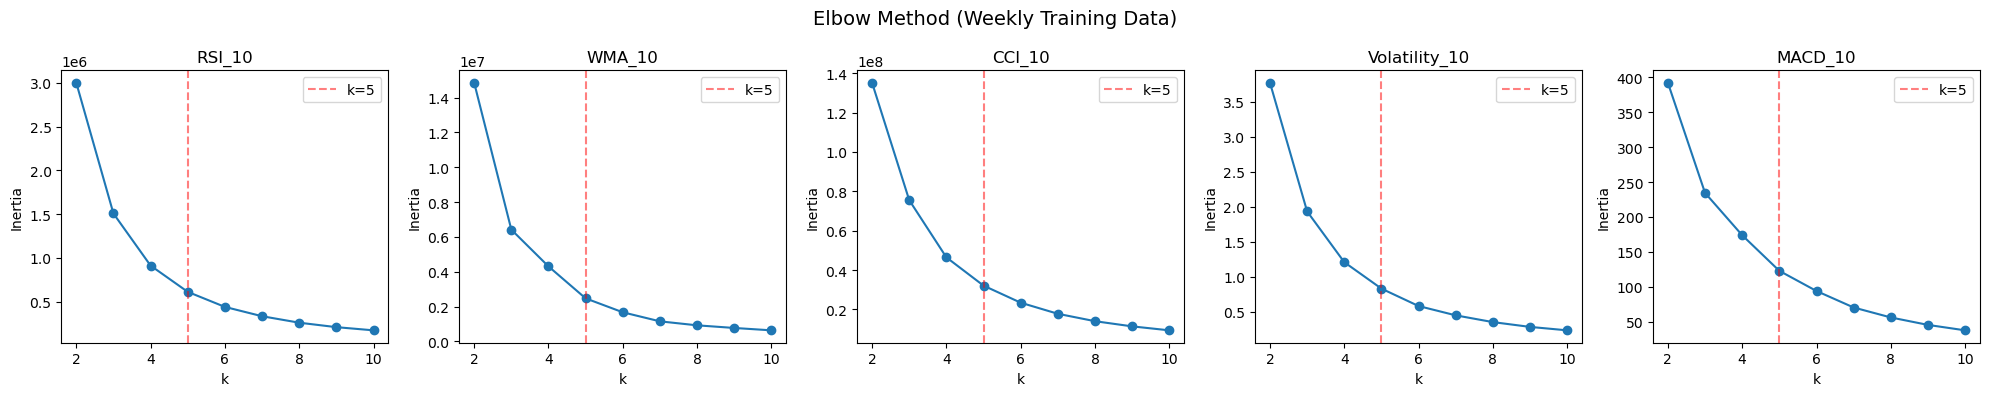

In [19]:
def elbow_plot(df, indicator_cols, k_range=range(2, 11), random_state=42):
    """Elbow method to validate k=5 choice."""
    n = len(indicator_cols)
    fig, axes = plt.subplots(1, n, figsize=(4 * n, 4))
    if n == 1:
        axes = [axes]
    for ax, col in zip(axes, indicator_cols):
        values = df[col].dropna().values.reshape(-1, 1)
        inertias = []
        for k in k_range:
            km = KMeans(n_clusters=k, random_state=random_state, n_init=10)
            km.fit(values)
            inertias.append(km.inertia_)
        ax.plot(list(k_range), inertias, marker="o")
        ax.axvline(x=5, color="r", linestyle="--", alpha=0.5, label="k=5")
        ax.set_xlabel("k")
        ax.set_ylabel("Inertia")
        ax.set_title(col)
        ax.legend()
    plt.suptitle("Elbow Method (Weekly Training Data)", fontsize=14)
    plt.tight_layout()
    plt.show()

# Use original (continuous) training data for elbow plot
weekly_train_orig = weekly_eda_df[weekly_eda_df["Date"] < weekly_cutoff]
elbow_plot(weekly_train_orig, weekly_indicator_cols)

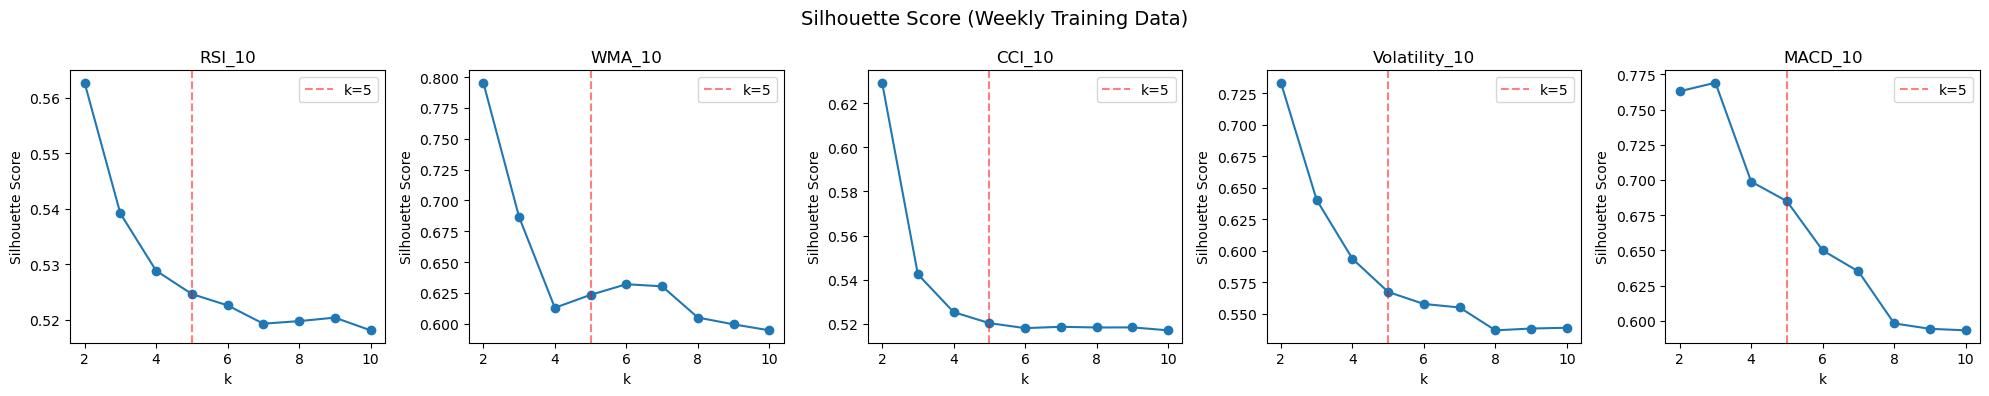

In [38]:
def silhouette_plot(df, indicator_cols, k_range=range(2, 11), random_state=42):
    """Silhouette score for each indicator across a range of k values."""
    n = len(indicator_cols)
    fig, axes = plt.subplots(1, n, figsize=(4 * n, 4))
    if n == 1:
        axes = [axes]
    for ax, col in zip(axes, indicator_cols):
        values = df[col].dropna().values.reshape(-1, 1)
        scores = []
        for k in k_range:
            km = KMeans(n_clusters=k, random_state=random_state, n_init=10)
            labels = km.fit_predict(values)
            scores.append(silhouette_score(values, labels))
        ax.plot(list(k_range), scores, marker="o")
        ax.axvline(x=5, color="r", linestyle="--", alpha=0.5, label="k=5")
        ax.set_xlabel("k")
        ax.set_ylabel("Silhouette Score")
        ax.set_title(col)
        ax.legend()
    plt.suptitle("Silhouette Score (Weekly Training Data)", fontsize=14)
    plt.tight_layout()
    plt.show()

silhouette_plot(weekly_train_orig, weekly_indicator_cols)

### 9.6 Original vs Discretised Comparison

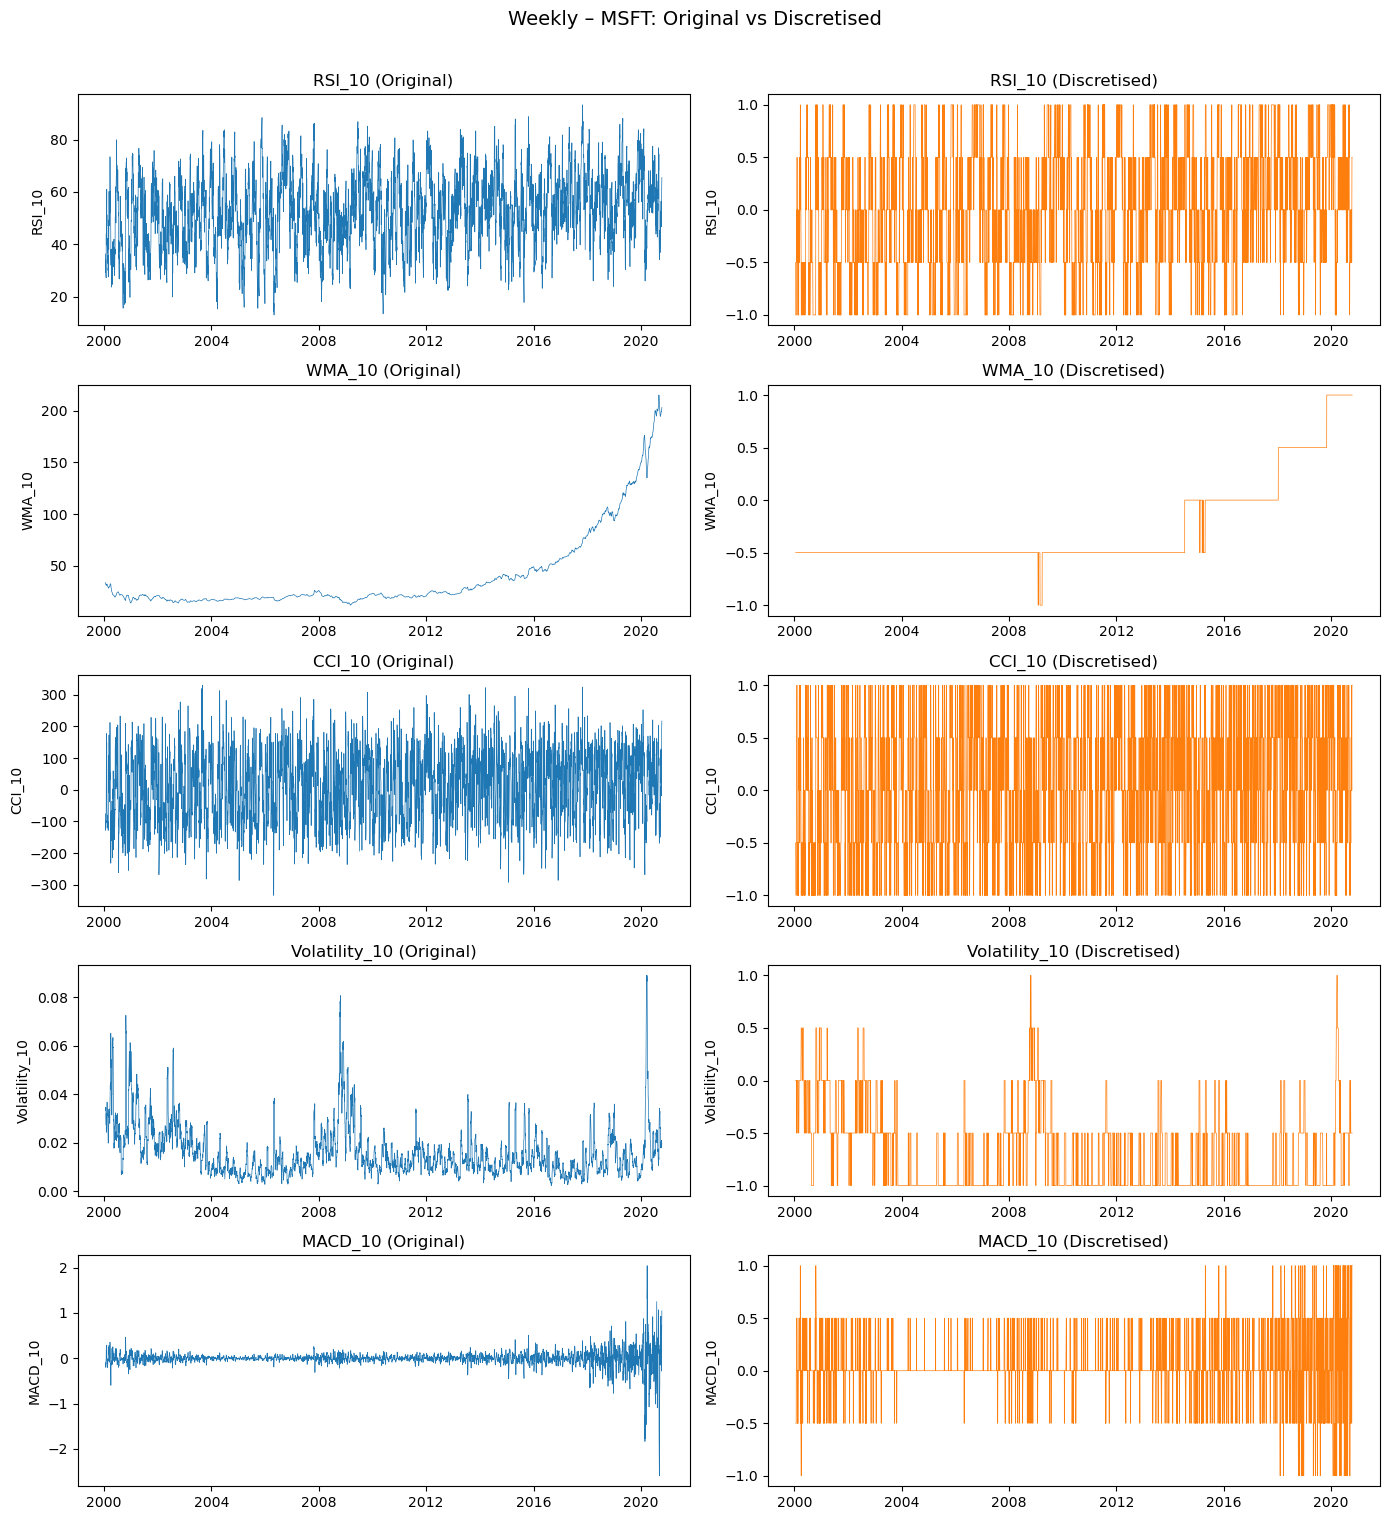

In [39]:
def plot_discretisation_example(original_df, disc_df, indicator_cols, ticker, horizon_name):
    """Side-by-side: original continuous vs discretised ordinal for one ticker."""
    orig = original_df[original_df["Ticker"] == ticker].sort_values("Date")
    disc = disc_df[disc_df["Ticker"] == ticker].sort_values("Date")

    n = len(indicator_cols)
    fig, axes = plt.subplots(n, 2, figsize=(14, 3 * n))
    fig.suptitle(f"{horizon_name} \u2013 {ticker}: Original vs Discretised", fontsize=14, y=1.01)

    for i, col in enumerate(indicator_cols):
        axes[i, 0].plot(orig["Date"], orig[col], linewidth=0.5)
        axes[i, 0].set_ylabel(col)
        axes[i, 0].set_title(f"{col} (Original)")

        axes[i, 1].plot(disc["Date"], disc[col], linewidth=0.5, color="tab:orange")
        axes[i, 1].set_ylabel(col)
        axes[i, 1].set_title(f"{col} (Discretised)")
        axes[i, 1].set_yticks(ORDINAL_LABELS)

    plt.tight_layout()
    plt.show()

# Example: MSFT weekly (training period)
plot_discretisation_example(
    weekly_train_orig, weekly_train, weekly_indicator_cols, "MSFT", "Weekly"
)

## 10. Modelling

We train separate models **per ticker, per horizon** on the 5 discretised technical indicators.
The target variable is the forward-looking return for each horizon (Weekly_Return, Monthly_Return, Yearly_Return).

**Models:**
1. Baseline — Rolling historical mean of returns
2. MLR — Multiple Linear Regression
3. Ridge & Lasso — Regularised linear models (alpha via cross-validation)
4. ARIMA — Univariate + SARIMAX with exogenous indicators
5. SVR — Support Vector Regression
6. ANN — MLP Regressor (sklearn)

**Evaluation:** MAE, RMSE, R² per ticker per horizon, aggregated into summary DataFrames.

In [21]:
# ========= Modelling imports =========

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# ARIMA / SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

### 10.1 Helper Functions

In [22]:
# ========= Modelling helpers =========

HORIZONS = ["weekly", "monthly", "yearly"]
TICKERS  = [t for tickers in industry_groups.values() for t in tickers]


def get_horizon_config(horizon):
    """Return (train_df, test_df, indicator_cols, target_col) for a horizon."""
    configs = {
        "weekly":  (weekly_train, weekly_test, weekly_indicator_cols, "Weekly_Return"),
        "monthly": (monthly_train, monthly_test, monthly_indicator_cols, "Monthly_Return"),
        "yearly":  (yearly_train, yearly_test, yearly_indicator_cols, "Yearly_Return"),
    }
    return configs[horizon]


def get_ticker_data(train_df, test_df, indicator_cols, target_col, ticker):
    """
    Extract feature matrices and target vectors for a single ticker.
    Returns X_train, y_train, X_test, y_test (numpy arrays).
    """
    tr = train_df[train_df["Ticker"] == ticker].dropna(subset=[target_col])
    te = test_df[test_df["Ticker"] == ticker].dropna(subset=[target_col])

    X_train = tr[indicator_cols].values
    y_train = tr[target_col].values
    X_test  = te[indicator_cols].values
    y_test  = te[target_col].values

    return X_train, y_train, X_test, y_test


def evaluate_predictions(y_true, y_pred):
    """Compute MAE, RMSE, R² for a prediction vector."""
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "R2": r2}


def collect_results(results_list):
    """Convert list of result dicts into a tidy DataFrame."""
    return pd.DataFrame(results_list)

In [23]:
# Master results list — every model appends here
all_results = []

### 10.2 Baseline: Rolling Historical Mean

In [24]:
def baseline_rolling_mean(train_df, test_df, target_col, ticker, window=60):
    """
    Baseline: predict future return = expanding mean of past returns.
    No features used — purely historical return average.
    shift(1) ensures no look-ahead bias.
    """
    tr = train_df[train_df["Ticker"] == ticker].sort_values("Date")
    te = test_df[test_df["Ticker"] == ticker].sort_values("Date")

    combined = pd.concat([tr[[target_col]], te[[target_col]]], axis=0)
    rolling_mean = combined[target_col].expanding(min_periods=window).mean().shift(1)

    y_pred = rolling_mean.loc[te.index].values
    y_true = te[target_col].values

    mask = ~np.isnan(y_pred)
    return y_true[mask], y_pred[mask]


# --- Run baseline ---
for horizon in HORIZONS:
    train_df, test_df, ind_cols, target_col = get_horizon_config(horizon)
    for ticker in TICKERS:
        y_true, y_pred = baseline_rolling_mean(train_df, test_df, target_col, ticker)
        if len(y_true) > 0:
            metrics = evaluate_predictions(y_true, y_pred)
            all_results.append({
                "Model": "Baseline (Rolling Mean)",
                "Horizon": horizon.capitalize(),
                "Ticker": ticker, **metrics
            })

print(f"Baseline complete: {len([r for r in all_results if r['Model'] == 'Baseline (Rolling Mean)'])} results")

Baseline complete: 29 results


### 10.3 Multiple Linear Regression (MLR)

In [25]:
for horizon in HORIZONS:
    train_df, test_df, ind_cols, target_col = get_horizon_config(horizon)
    for ticker in TICKERS:
        X_train, y_train, X_test, y_test = get_ticker_data(
            train_df, test_df, ind_cols, target_col, ticker
        )
        if len(X_train) == 0 or len(X_test) == 0:
            continue

        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        metrics = evaluate_predictions(y_test, y_pred)
        all_results.append({
            "Model": "MLR", "Horizon": horizon.capitalize(),
            "Ticker": ticker, **metrics
        })

print(f"MLR complete: {len([r for r in all_results if r['Model'] == 'MLR'])} results")

MLR complete: 29 results


### 10.4 Ridge & Lasso Regression (Cross-Validated Alpha)

In [26]:
alphas = np.logspace(-4, 4, 50)
tscv = TimeSeriesSplit(n_splits=5)

for horizon in HORIZONS:
    train_df, test_df, ind_cols, target_col = get_horizon_config(horizon)
    for ticker in TICKERS:
        X_train, y_train, X_test, y_test = get_ticker_data(
            train_df, test_df, ind_cols, target_col, ticker
        )
        if len(X_train) == 0 or len(X_test) == 0:
            continue

        # --- Ridge ---
        ridge_cv = RidgeCV(alphas=alphas, cv=tscv)
        ridge_cv.fit(X_train, y_train)
        y_pred_ridge = ridge_cv.predict(X_test)

        metrics = evaluate_predictions(y_test, y_pred_ridge)
        all_results.append({
            "Model": f"Ridge (alpha={ridge_cv.alpha_:.4f})",
            "Horizon": horizon.capitalize(),
            "Ticker": ticker, **metrics
        })

        # --- Lasso ---
        lasso_cv = LassoCV(alphas=alphas, cv=tscv, max_iter=10000)
        lasso_cv.fit(X_train, y_train)
        y_pred_lasso = lasso_cv.predict(X_test)

        metrics = evaluate_predictions(y_test, y_pred_lasso)
        all_results.append({
            "Model": f"Lasso (alpha={lasso_cv.alpha_:.4f})",
            "Horizon": horizon.capitalize(),
            "Ticker": ticker, **metrics
        })

print(f"Ridge complete: {len([r for r in all_results if 'Ridge' in r['Model']])} results")
print(f"Lasso complete: {len([r for r in all_results if 'Lasso' in r['Model']])} results")

Ridge complete: 29 results
Lasso complete: 29 results


### 10.5 ARIMA (Univariate) & SARIMAX (with Exogenous Indicators)

In [27]:
def fit_arima_for_ticker(train_df, test_df, indicator_cols, target_col,
                         ticker, horizon_name):
    """
    Fit univariate ARIMA(5,0,1) and SARIMAX(5,0,1) with exogenous indicators
    for a single ticker. Returns list of result dicts.
    """
    results = []

    tr = train_df[train_df["Ticker"] == ticker].sort_values("Date").dropna(subset=[target_col])
    te = test_df[test_df["Ticker"] == ticker].sort_values("Date").dropna(subset=[target_col])

    if len(tr) < 50 or len(te) < 10:
        return results

    y_train = tr[target_col].values
    y_test  = te[target_col].values
    X_train_exog = tr[indicator_cols].values
    X_test_exog  = te[indicator_cols].values

    # --- Univariate ARIMA(5,0,1) ---
    # d=0: returns are already stationary (percent changes)
    try:
        arima_fit = ARIMA(y_train, order=(5, 0, 1)).fit()
        y_pred_arima = arima_fit.forecast(steps=len(y_test))

        metrics = evaluate_predictions(y_test, y_pred_arima)
        results.append({
            "Model": "ARIMA(5,0,1)",
            "Horizon": horizon_name.capitalize(),
            "Ticker": ticker, **metrics
        })
    except Exception as e:
        print(f"  ARIMA failed for {ticker}/{horizon_name}: {e}")

    # --- SARIMAX with exogenous indicators ---
    try:
        sarimax_fit = SARIMAX(
            y_train, exog=X_train_exog,
            order=(5, 0, 1), seasonal_order=(0, 0, 0, 0),
            enforce_stationarity=False, enforce_invertibility=False
        ).fit(disp=False, maxiter=200)

        y_pred_sarimax = sarimax_fit.forecast(steps=len(y_test), exog=X_test_exog)

        metrics = evaluate_predictions(y_test, y_pred_sarimax)
        results.append({
            "Model": "SARIMAX(5,0,1)+Exog",
            "Horizon": horizon_name.capitalize(),
            "Ticker": ticker, **metrics
        })
    except Exception as e:
        print(f"  SARIMAX failed for {ticker}/{horizon_name}: {e}")

    return results


# --- Run ARIMA/SARIMAX ---
for horizon in HORIZONS:
    train_df, test_df, ind_cols, target_col = get_horizon_config(horizon)
    print(f"\n{'='*40} {horizon.upper()} {'='*40}")
    for ticker in TICKERS:
        print(f"  {ticker}...", end=" ")
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            ticker_results = fit_arima_for_ticker(
                train_df, test_df, ind_cols, target_col, ticker, horizon
            )
        all_results.extend(ticker_results)
        print(f"done ({len(ticker_results)} models)")

arima_count = len([r for r in all_results if "ARIMA" in r["Model"] or "SARIMAX" in r["Model"]])
print(f"\nARIMA/SARIMAX complete: {arima_count} results")


======================================== WEEKLY ========================================
done (2 models)
done (2 models)
done (2 models)
done (2 models)
done (2 models)
done (2 models)
done (2 models)
done (2 models)
done (2 models)
done (2 models)

======================================== MONTHLY ========================================
done (2 models)
done (2 models)
done (2 models)
done (2 models)
  MP... done (0 models)
done (2 models)
done (2 models)
done (2 models)
done (2 models)
done (2 models)

======================================== YEARLY ========================================
done (2 models)
done (2 models)
done (2 models)
done (2 models)
  MP... done (0 models)
done (2 models)
done (2 models)
done (2 models)
done (2 models)
done (2 models)

ARIMA/SARIMAX complete: 56 results


### 10.6 Support Vector Regression (SVR)

In [28]:
# Kernel configs: model name → {kernel, param_grid for GridSearchCV}
kernel_configs = {
    "SVR (RBF)": {
        "kernel": "rbf",
        "param_grid": {
            "C":       [0.1, 1, 10, 100],
            "epsilon": [0.001, 0.01, 0.1],
            "gamma":   ["scale", "auto"],
        },
    },
    "SVR (Linear)": {
        "kernel": "linear",
        "param_grid": {
            "C":       [0.1, 1, 10, 100],
            "epsilon": [0.001, 0.01, 0.1],
        },
    },
    "SVR (Poly)": {
        "kernel": "poly",
        "param_grid": {
            "C":       [0.1, 1, 10],
            "epsilon": [0.001, 0.01, 0.1],
            "degree":  [2, 3],
            "coef0":   [0, 1],
        },
    },
}

for horizon in HORIZONS:
    train_df, test_df, ind_cols, target_col = get_horizon_config(horizon)
    for ticker in TICKERS:
        X_train, y_train, X_test, y_test = get_ticker_data(
            train_df, test_df, ind_cols, target_col, ticker
        )
        if len(X_train) == 0 or len(X_test) == 0:
            continue

        # Scale features and target for SVR
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()

        X_train_sc = scaler_X.fit_transform(X_train)
        X_test_sc  = scaler_X.transform(X_test)
        y_train_sc = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

        # GridSearchCV with TimeSeriesSplit:
        #   - Inner CV (tscv) selects optimal hyperparameters on training data
        #   - Outer test set (X_test_sc) validates the chosen model
        for model_name, cfg in kernel_configs.items():
            gs = GridSearchCV(
                SVR(kernel=cfg["kernel"]),
                cfg["param_grid"],
                cv=tscv,
                scoring="neg_mean_absolute_error",
                n_jobs=-1,
            )
            gs.fit(X_train_sc, y_train_sc)

            y_pred_sc = gs.best_estimator_.predict(X_test_sc)
            y_pred = scaler_y.inverse_transform(y_pred_sc.reshape(-1, 1)).ravel()

            metrics = evaluate_predictions(y_test, y_pred)
            all_results.append({
                "Model": model_name, "Horizon": horizon.capitalize(),
                "Ticker": ticker, **metrics
            })

svr_count = len([r for r in all_results if r["Model"].startswith("SVR")])
print(f"SVR complete: {svr_count} results")

SVR complete: 87 results


### 10.7 Artificial Neural Network (MLP Regressor)

In [29]:
for horizon in HORIZONS:
    train_df, test_df, ind_cols, target_col = get_horizon_config(horizon)
    for ticker in TICKERS:
        X_train, y_train, X_test, y_test = get_ticker_data(
            train_df, test_df, ind_cols, target_col, ticker
        )
        if len(X_train) == 0 or len(X_test) == 0:
            continue

        # Scale features for MLP
        scaler_X = StandardScaler()
        X_train_sc = scaler_X.fit_transform(X_train)
        X_test_sc  = scaler_X.transform(X_test)

        mlp = MLPRegressor(
            hidden_layer_sizes=(32, 16),
            activation="relu",
            solver="adam",
            alpha=0.001,
            learning_rate="adaptive",
            learning_rate_init=0.001,
            max_iter=500,
            early_stopping=True,
            validation_fraction=0.15,
            n_iter_no_change=20,
            random_state=42,
        )
        mlp.fit(X_train_sc, y_train)
        y_pred = mlp.predict(X_test_sc)

        metrics = evaluate_predictions(y_test, y_pred)
        all_results.append({
            "Model": "ANN (MLP)", "Horizon": horizon.capitalize(),
            "Ticker": ticker, **metrics
        })

print(f"ANN complete: {len([r for r in all_results if r['Model'] == 'ANN (MLP)'])} results")

ANN complete: 29 results


### 10.8 Results Summary & Comparison

In [30]:
results_df = collect_results(all_results)

# Normalise model names for grouping (strip per-ticker alpha from Ridge/Lasso)
results_df["Model_Group"] = results_df["Model"].apply(
    lambda x: "Ridge" if "Ridge" in x else ("Lasso" if "Lasso" in x else x)
)

print(f"Total results: {len(results_df)}")
print(f"Models: {results_df['Model_Group'].nunique()}")
print(f"Horizons: {results_df['Horizon'].nunique()}")
print(f"Tickers: {results_df['Ticker'].nunique()}")

# Summary by model and horizon (mean ± std across tickers)
summary = (
    results_df
    .groupby(["Model_Group", "Horizon"])[["MAE", "RMSE", "R2"]]
    .agg(["mean", "std"])
    .round(6)
)
display(summary)

Total results: 288
Models: 10
Horizons: 3
Tickers: 10


MAE                RMSE            \
                                     mean       std      mean       std   
Model_Group             Horizon                                           
ANN (MLP)               Monthly  0.200683  0.235544  0.249924  0.281971   
                        Weekly   0.241954  0.428178  0.341651  0.634962   
                        Yearly   0.572331  0.465749  0.672870  0.508325   
ARIMA(5,0,1)            Monthly  0.067925  0.023292  0.087676  0.030728   
                        Weekly   0.037272  0.017790  0.049336  0.024281   
                        Yearly   0.332246  0.232300  0.398841  0.258465   
Baseline (Rolling Mean) Monthly  0.078197  0.039242  0.102082  0.054147   
                        Weekly   0.037116  0.017443  0.049245  0.024129   
                        Yearly   0.330516  0.213811  0.405303  0.257540   
Lasso                   Monthly  0.079530  0.042380  0.105356  0.062662   
                        Weekly   0.037396  0.018122  0.049485  0.024717   
                        Yearly   0.353147  0.205827  0.433159  0.252552   
MLR                     Monthly  0.090092  0.056483  0.117118  0.076359   
                        Weekly   0.042619  0.027792  0.055944  0.036991   
                        Yearly   0.472873  0.239645  0.559672  0.282858   
Ridge                   Monthly  0.079749  0.043003  0.105497  0.063181   
                        Weekly   0.038063  0.019874  0.050546  0.027606   
                        Yearly   0.369873  0.212700  0.447964  0.256895   
SARIMAX(5,0,1)+Exog     Monthly  0.079161  0.033502  0.100977  0.043828   
                        Weekly   0.044935  0.022511  0.057946  0.029724   
                        Yearly   0.345377  0.306640  0.409225  0.337492   
SVR (Linear)            Monthly  0.088852  0.053192  0.115750  0.072525   
                        Weekly   0.039041  0.020607  0.051710  0.028485   
                        Yearly   0.463764  0.220134  0.551585  0.267459   
SVR (Poly)              Monthly  0.169443  0.171503  0.239092  0.264234   
                        Weekly   0.073974  0.116400  0.109469  0.189731   
                        Yearly   0.989719  1.011989  1.323081  1.535169   
SVR (RBF)               Monthly  0.081145  0.039479  0.108358  0.062003   
                        Weekly   0.037433  0.017442  0.049830  0.024601   
                        Yearly   0.410133  0.234310  0.497533  0.294126   

                                         R2              
                                       mean         std  
Model_Group             Horizon                          
ANN (MLP)               Monthly   -4.388830    5.962486  
                        Weekly  -103.499250  289.742558  
                        Yearly    -2.987523    4.599542  
ARIMA(5,0,1)            Monthly   -0.018806    0.023075  
                        Weekly    -0.006609    0.007277  
                        Yearly    -0.330577    0.696120  
Baseline (Rolling Mean) Monthly   -0.018606    0.021118  
                        Weekly    -0.003980    0.004608  
                        Yearly    -0.259055    0.226793  
Lasso                   Monthly   -0.032257    0.042884  
                        Weekly    -0.009121    0.014197  
                        Yearly    -0.550657    0.586681  
MLR                     Monthly   -0.260205    0.519196  
                        Weekly    -0.193548    0.352788  
                        Yearly    -1.834498    1.551493  
Ridge                   Monthly   -0.032910    0.046646  
                        Weekly    -0.030736    0.078884  
                        Yearly    -0.696645    0.793052  
SARIMAX(5,0,1)+Exog     Monthly   -0.320293    0.210405  
                        Weekly    -0.379754    0.181081  
                        Yearly    -0.175335    0.405814  
SVR (Linear)            Monthly   -0.244133    0.439798  
                        Weekly    -0.071885    0.104883  
                        Yearly    -1.844995    1.72320

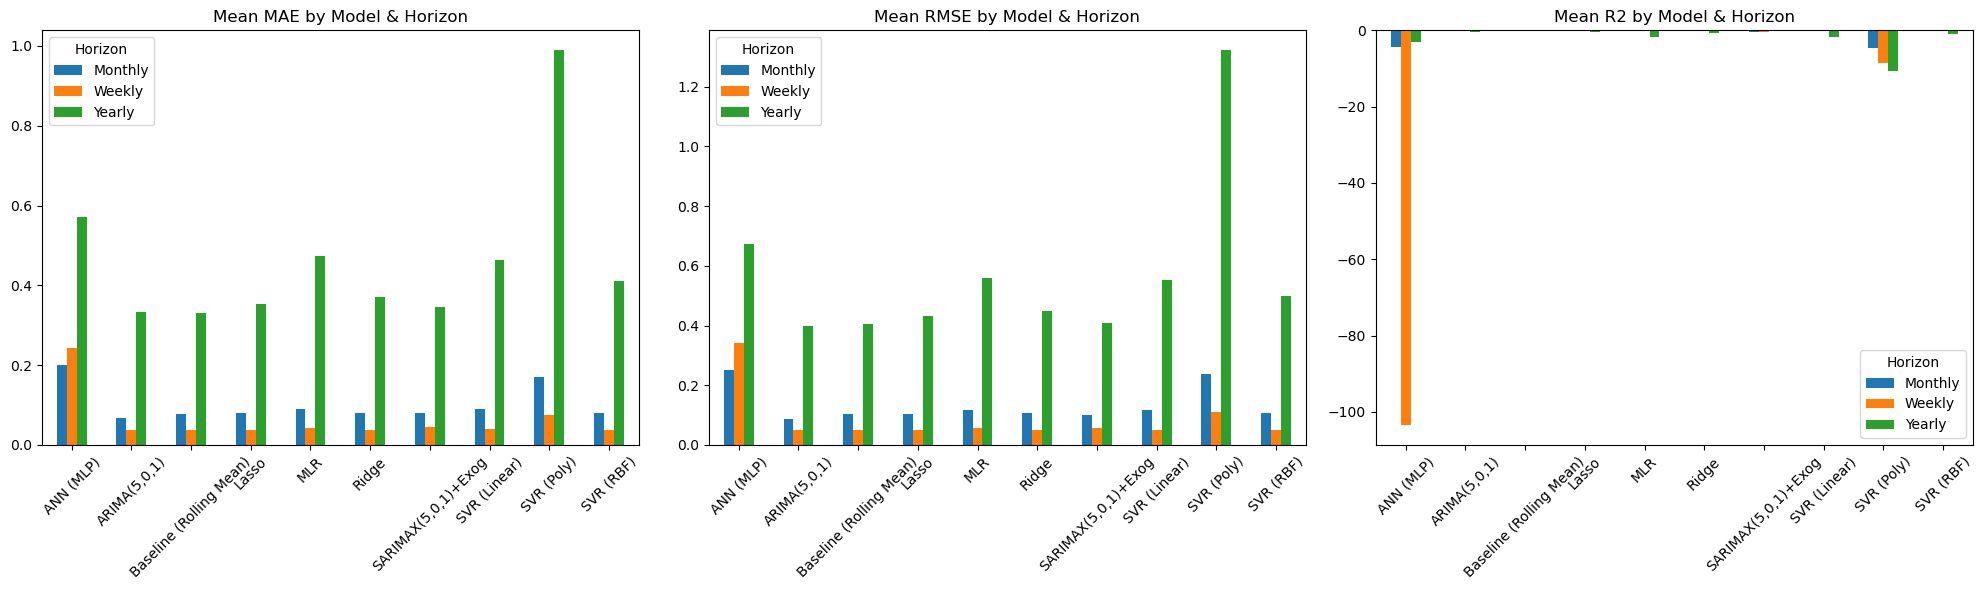

In [31]:
# Bar chart: MAE, RMSE, R² by model and horizon
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=False)

for ax, metric in zip(axes, ["MAE", "RMSE", "R2"]):
    pivot = (
        results_df
        .groupby(["Model_Group", "Horizon"])[metric]
        .mean()
        .unstack("Horizon")
    )
    pivot.plot(kind="bar", ax=ax, rot=45)
    ax.set_title(f"Mean {metric} by Model & Horizon")
    ax.set_xlabel("")
    ax.legend(title="Horizon")

plt.tight_layout()
plt.show()

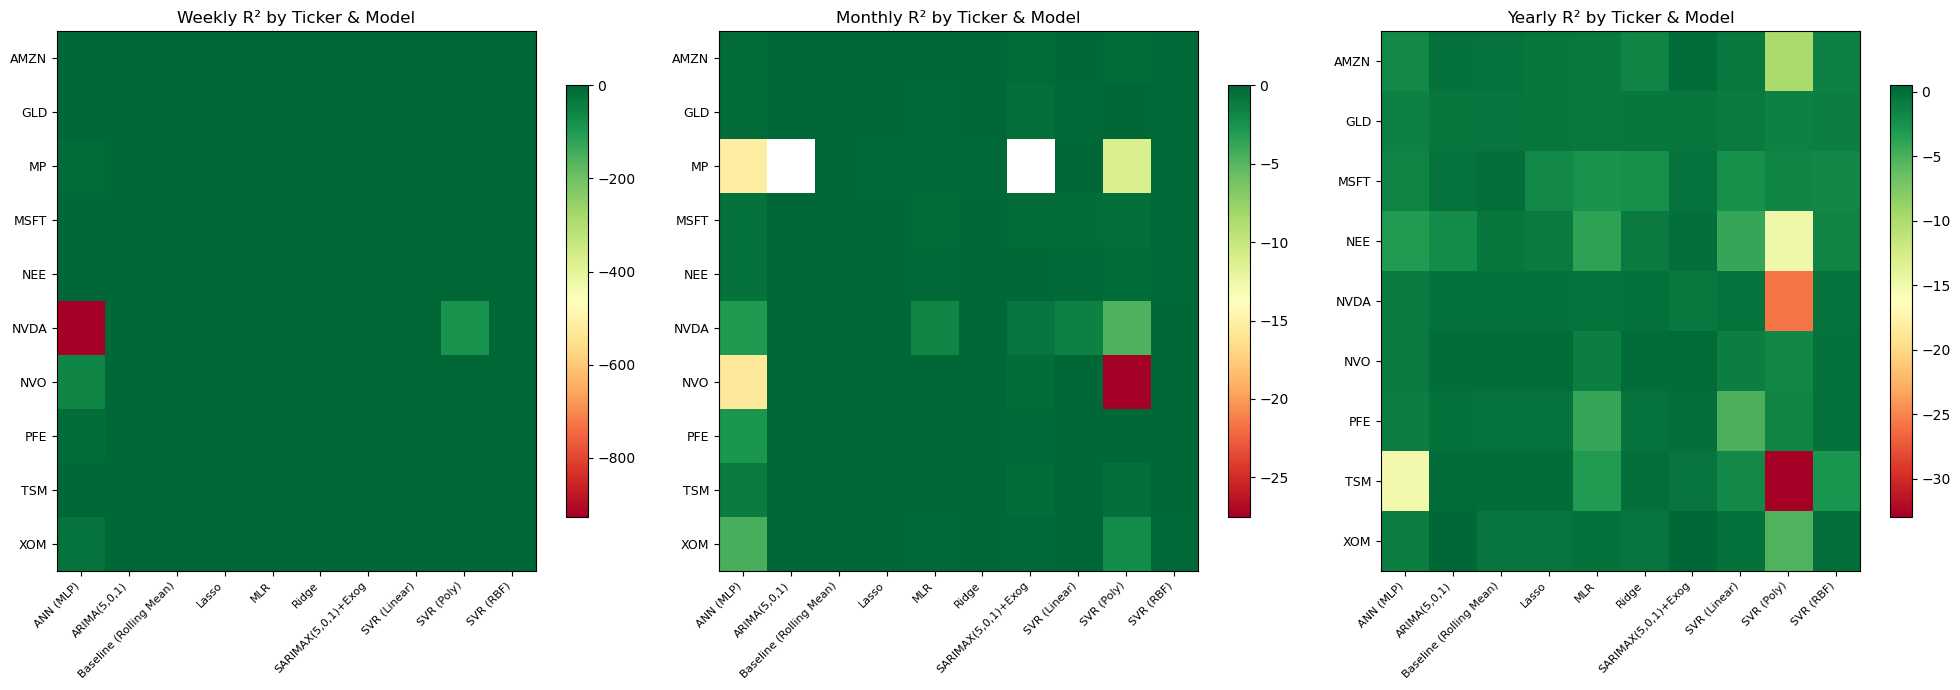

In [32]:
# Per-ticker R² heatmap (one panel per horizon)
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

for ax, horizon_name in zip(axes, ["Weekly", "Monthly", "Yearly"]):
    subset = results_df[results_df["Horizon"] == horizon_name]
    pivot = subset.pivot_table(
        index="Ticker", columns="Model_Group", values="R2", aggfunc="mean"
    )
    im = ax.imshow(pivot.values, cmap="RdYlGn", aspect="auto")
    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels(pivot.columns, rotation=45, ha="right", fontsize=8)
    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels(pivot.index, fontsize=9)
    ax.set_title(f"{horizon_name} R² by Ticker & Model")
    plt.colorbar(im, ax=ax, shrink=0.8)

plt.tight_layout()
plt.show()

In [33]:
# Best model per (Horizon, Ticker) by R²
best_models = (
    results_df
    .sort_values("R2", ascending=False)
    .groupby(["Horizon", "Ticker"])
    .first()
    .reset_index()[["Horizon", "Ticker", "Model", "MAE", "RMSE", "R2"]]
)

print("Best model per (Horizon, Ticker):")
display(best_models)

# Count wins per model group
win_counts = best_models["Model"].apply(
    lambda x: "Ridge" if "Ridge" in x else ("Lasso" if "Lasso" in x else x)
).value_counts()
print("\nModel win counts (by R²):")
display(win_counts)

Best model per (Horizon, Ticker):


Horizon Ticker                     Model       MAE      RMSE        R2
0   Monthly   AMZN              ARIMA(5,0,1)  0.069601  0.092043 -0.020997
1   Monthly    GLD   Baseline (Rolling Mean)  0.034110  0.042998 -0.010308
2   Monthly     MP   Baseline (Rolling Mean)  0.170525  0.232264 -0.031149
3   Monthly   MSFT  Ridge (alpha=10000.0000)  0.052717  0.066011  0.002017
4   Monthly    NEE   Baseline (Rolling Mean)  0.061677  0.078970 -0.009264
5   Monthly   NVDA   Baseline (Rolling Mean)  0.118686  0.153936 -0.017347
6   Monthly    NVO              ARIMA(5,0,1)  0.071732  0.094341 -0.000335
7   Monthly    PFE   Baseline (Rolling Mean)  0.058779  0.074137 -0.001781
8   Monthly    TSM    Ridge (alpha=494.1713)  0.083991  0.105644 -0.010579
9   Monthly    XOM   Baseline (Rolling Mean)  0.060245  0.079951 -0.073139
10   Weekly   AMZN   Baseline (Rolling Mean)  0.035663  0.048064 -0.005101
11   Weekly    GLD   Baseline (Rolling Mean)  0.016609  0.021519 -0.003092
12   Weekly     MP   Baseline (Rolling Mean)  0.078192  0.107690 -0.004240
13   Weekly   MSFT   Ridge (alpha=2222.9965)  0.026307  0.033766  0.001665
14   Weekly    NEE   Baseline (Rolling Mean)  0.028209  0.037337 -0.002947
15   Weekly   NVDA   Baseline (Rolling Mean)  0.054218  0.069586 -0.002542
16   Weekly    NVO    Ridge (alpha=719.6857)  0.035518  0.049063  0.004205
17   Weekly    PFE              ARIMA(5,0,1)  0.027855  0.036376  0.002208
18   Weekly    TSM   Baseline (Rolling Mean)  0.038516  0.049377 -0.002837
19   Weekly    XOM                 SVR (RBF)  0.029748  0.039079  0.002684
20   Yearly   AMZN       SARIMAX(5,0,1)+Exog  0.299862  0.356870  0.022595
21   Yearly    GLD   Baseline (Rolling Mean)  0.167061  0.219148 -0.409835
22   Yearly   MSFT   Baseline (Rolling Mean)  0.189333  0.236632 -0.015089
23   Yearly    NEE       SARIMAX(5,0,1)+Exog  0.153308  0.188083 -0.097709
24   Yearly   NVDA   Baseline (Rolling Mean)  0.857545  1.044981 -0.173635
25   Yearly    NVO       SARIMAX(5,0,1)+Exog  0.352750  0.410339  0.195883
26   Yearly    PFE       SARIMAX(5,0,1)+Exog  0.205781  0.238161 -0.019162
27   Yearly    TSM              ARIMA(5,0,1)  0.330292  0.401333  0.129327
28   Yearly    XOM       SARIMAX(5,0,1)+Exog  0.136159  0.196100  0.518194


Model win counts (by R²):


Model
Baseline (Rolling Mean)    15
SARIMAX(5,0,1)+Exog         5
ARIMA(5,0,1)                4
Ridge                       4
SVR (RBF)                   1
Name: count, dtype: int64

### 10.9 Store Predictions for Portfolio Optimisation

Save the test-set predictions from each model so they can feed the downstream
Mean-Variance Optimisation and backtesting pipeline.

In [34]:
def run_all_models_and_store_predictions():
    """
    Re-train all sklearn models and store predictions in a dict keyed by
    (model_name, horizon, ticker) -> {y_pred, y_test, dates}.
    This is the bridge to the portfolio optimisation phase.
    """
    predictions = {}

    for horizon in HORIZONS:
        train_df, test_df, ind_cols, target_col = get_horizon_config(horizon)

        for ticker in TICKERS:
            X_train, y_train, X_test, y_test = get_ticker_data(
                train_df, test_df, ind_cols, target_col, ticker
            )
            te = test_df[test_df["Ticker"] == ticker].dropna(subset=[target_col])
            test_dates = te["Date"].values

            if len(X_train) == 0 or len(X_test) == 0:
                continue

            base = {"y_test": y_test, "dates": test_dates}

            # MLR
            lr = LinearRegression().fit(X_train, y_train)
            predictions[("MLR", horizon, ticker)] = {
                "y_pred": lr.predict(X_test), **base
            }

            # Ridge
            ridge = RidgeCV(alphas=np.logspace(-4, 4, 50),
                            cv=TimeSeriesSplit(n_splits=5))
            ridge.fit(X_train, y_train)
            predictions[("Ridge", horizon, ticker)] = {
                "y_pred": ridge.predict(X_test), **base
            }

            # Lasso
            lasso = LassoCV(alphas=np.logspace(-4, 4, 50),
                            cv=TimeSeriesSplit(n_splits=5), max_iter=10000)
            lasso.fit(X_train, y_train)
            predictions[("Lasso", horizon, ticker)] = {
                "y_pred": lasso.predict(X_test), **base
            }

            # SVR
            scaler_X = StandardScaler()
            scaler_y = StandardScaler()
            X_tr_sc = scaler_X.fit_transform(X_train)
            X_te_sc = scaler_X.transform(X_test)
            y_tr_sc = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()
            svr = SVR(kernel="rbf", C=1.0, epsilon=0.01)
            svr.fit(X_tr_sc, y_tr_sc)
            y_pred_sc = svr.predict(X_te_sc)
            predictions[("SVR", horizon, ticker)] = {
                "y_pred": scaler_y.inverse_transform(y_pred_sc.reshape(-1, 1)).ravel(),
                **base
            }

            # ANN
            scaler_X2 = StandardScaler()
            X_tr_sc2 = scaler_X2.fit_transform(X_train)
            X_te_sc2 = scaler_X2.transform(X_test)
            mlp = MLPRegressor(
                hidden_layer_sizes=(32, 16), activation="relu",
                solver="adam", alpha=0.001, learning_rate="adaptive",
                max_iter=500, early_stopping=True,
                validation_fraction=0.15, n_iter_no_change=20,
                random_state=42
            )
            mlp.fit(X_tr_sc2, y_train)
            predictions[("ANN", horizon, ticker)] = {
                "y_pred": mlp.predict(X_te_sc2), **base
            }

    return predictions


model_predictions = run_all_models_and_store_predictions()
print(f"Stored predictions: {len(model_predictions)} (model, horizon, ticker) combinations")

Stored predictions: 145 (model, horizon, ticker) combinations


In [35]:

# =====================================================================
# 11.0  PORTFOLIO OPTIMISATION — CONFIG & HELPER FUNCTIONS
# =====================================================================

from scipy.optimize import minimize

# ── Constants ─────────────────────────────────────────────────────────
RF_ANNUAL        = 0.02    # annual risk-free rate
MAX_WEIGHT       = 0.40    # max allocation per stock (long-only)
COV_WINDOW       = 252     # trading days for rolling covariance
PORTFOLIO_MODELS = ["MLR", "Ridge", "Lasso", "SVR", "ANN"]

# ── Daily returns pivot: index = Date, columns = TICKERS ──────────────
_full = (
    pd.concat([monthly_train, monthly_test])
    .drop_duplicates(subset=["Date", "Ticker"])
    .sort_values(["Ticker", "Date"])
)
daily_ret_pivot = (
    _full[["Date", "Ticker", "Daily_Return"]]
    .dropna(subset=["Daily_Return"])
    .pivot_table(index="Date", columns="Ticker", values="Daily_Return")
    .reindex(columns=TICKERS)
    .sort_index()
)
daily_ret_pivot.index = pd.to_datetime(daily_ret_pivot.index)

print(f"Daily returns pivot: {daily_ret_pivot.shape[0]:,} rows × {daily_ret_pivot.shape[1]} tickers")
print(f"Date range : {daily_ret_pivot.index[0].date()} → {daily_ret_pivot.index[-1].date()}")

# ── Helper: expected return DataFrame ────────────────────────────────
def build_expected_returns(model_name, preds):
    """
    Build a DataFrame of predicted monthly returns.
    Resamples to the last available prediction per calendar month.
    Returns: DataFrame indexed by month-end dates, columns = TICKERS.
    """
    frames = {}
    for ticker in TICKERS:
        key = (model_name, "monthly", ticker)
        if key not in preds:
            continue
        p = preds[key]
        s = pd.Series(p["y_pred"], index=pd.to_datetime(p["dates"]), name=ticker)
        frames[ticker] = s
    mu_df = pd.DataFrame(frames).reindex(columns=TICKERS).sort_index()
    # One prediction per calendar month (last available trading day)
    try:
        mu_monthly = mu_df.resample("ME").last().dropna(how="any")
    except ValueError:
        mu_monthly = mu_df.resample("M").last().dropna(how="any")
    return mu_monthly


# ── Helper: rolling annualised covariance matrix ──────────────────────
def build_rolling_cov(as_of_date, window=COV_WINDOW):
    """
    Annualised covariance matrix (252 × daily cov) from the last
    `window` trading days strictly before as_of_date.
    A small diagonal term ensures positive-definiteness.
    """
    hist    = daily_ret_pivot[daily_ret_pivot.index < as_of_date].tail(window)
    cov     = hist.cov() * 252
    med_val = np.nanmedian(cov.values)
    cov     = cov.fillna(med_val)
    return cov.values + np.eye(len(TICKERS)) * 1e-6


# ── MVO: maximise Sharpe (long-only, max 40 % per stock) ──────────────
def max_sharpe_weights(mu_annual, cov_annual):
    """
    SLSQP optimisation: maximise (w'μ − rf) / sqrt(w'Σw)
    subject to: Σwᵢ = 1,  0 ≤ wᵢ ≤ MAX_WEIGHT.
    Falls back to equal-weight if optimisation fails.
    """
    n  = len(mu_annual)
    w0 = np.ones(n) / n

    def neg_sharpe(w):
        ret = float(np.dot(w, mu_annual))
        vol = np.sqrt(max(float(w @ cov_annual @ w), 1e-12))
        return -(ret - RF_ANNUAL) / vol

    res = minimize(
        neg_sharpe, w0, method="SLSQP",
        bounds=[(0.0, MAX_WEIGHT)] * n,
        constraints=[{"type": "eq", "fun": lambda w: np.sum(w) - 1.0}],
        options={"ftol": 1e-9, "maxiter": 1000},
    )
    if res.success:
        w = np.clip(res.x, 0.0, MAX_WEIGHT)
        return w / w.sum()
    return w0  # equal-weight fallback


# ── Backtester ────────────────────────────────────────────────────────
def run_backtest(model_name, preds):
    """
    Monthly rolling backtest.
    At each rebalance date: compute MVO weights → apply to actual daily
    returns until the next rebalance.  No look-ahead bias.
    """
    mu_df          = build_expected_returns(model_name, preds)
    rebalance_dates = mu_df.index.tolist()

    port_daily_rets = []
    port_dates      = []
    weights_history = []
    valid_reb_dates = []

    for i, reb_date in enumerate(rebalance_dates):
        mu_vec  = mu_df.loc[reb_date].values * 12        # monthly → annual
        cov_mat = build_rolling_cov(reb_date)
        weights = max_sharpe_weights(mu_vec, cov_mat)

        next_reb = rebalance_dates[i + 1] if i + 1 < len(rebalance_dates) else None
        mask = daily_ret_pivot.index >= reb_date
        if next_reb is not None:
            mask &= daily_ret_pivot.index < next_reb
        period = daily_ret_pivot.loc[mask, TICKERS].fillna(0.0)
        if len(period) == 0:
            continue

        port_daily_rets.extend((period.values @ weights).tolist())
        port_dates.extend(period.index.tolist())
        weights_history.append(weights)
        valid_reb_dates.append(reb_date)

    daily_returns    = pd.Series(port_daily_rets, index=pd.to_datetime(port_dates)).sort_index()
    cumulative_wealth = (1 + daily_returns).cumprod()
    return {
        "daily_returns":     daily_returns,
        "cumulative_wealth": cumulative_wealth,
        "weights_history":   weights_history,
        "rebalance_dates":   valid_reb_dates,
    }


# ── Performance metrics ───────────────────────────────────────────────
def compute_portfolio_metrics(result, model_name):
    dr      = result["daily_returns"].dropna()
    ann_ret = dr.mean() * 252
    ann_vol = dr.std() * np.sqrt(252)
    sharpe  = (ann_ret - RF_ANNUAL) / ann_vol if ann_vol > 1e-10 else 0.0
    cum     = (1 + dr).cumprod()
    dd      = (cum - cum.cummax()) / cum.cummax()
    max_dd  = dd.min()
    cum_ret = float(cum.iloc[-1] - 1) if len(cum) > 0 else 0.0
    wh      = np.array(result["weights_history"])
    turnover = float(np.mean(np.sum(np.abs(np.diff(wh, axis=0)), axis=1))) if len(wh) > 1 else 0.0
    return {
        "Model":           model_name,
        "Sharpe Ratio":    round(sharpe,    4),
        "Ann. Return":     round(ann_ret,   4),
        "Ann. Volatility": round(ann_vol,   4),
        "Max Drawdown":    round(max_dd,    4),
        "Cum. Return":     round(cum_ret,   4),
        "Turnover":        round(turnover,  4),
    }

print("Portfolio helpers loaded ✓")


Daily returns pivot: 6,475 rows × 10 tickers
Date range : 2000-03-03 → 2025-11-28
Portfolio helpers loaded ✓


In [37]:

# =====================================================================
# 11.0b  RUN ALL BACKTESTS + BUILD PERFORMANCE TABLE
# =====================================================================

print("Generating model predictions (this may take ~1–2 min) ...")
predictions = run_all_models_and_store_predictions()
print(f"Predictions ready: {len(predictions)} entries\n")

backtest_results = {}
benchmark_results = {}
metrics_list      = []

# ── Model portfolios ──────────────────────────────────────────────────
for model in PORTFOLIO_MODELS:
    print(f"  [{model}] backtesting ...", end="  ")
    result = run_backtest(model, predictions)
    key    = (model, "monthly", "long_only")
    backtest_results[key] = result
    m = compute_portfolio_metrics(result, model)
    metrics_list.append(m)
    print(f"{len(result['rebalance_dates'])} rebalances  |  Sharpe = {m['Sharpe Ratio']:.3f}")

# ── Equal-weight benchmark ────────────────────────────────────────────
print(f"\n  [Equal-Weight] computing ...", end="  ")
test_start = min(
    backtest_results[(m2, "monthly", "long_only")]["daily_returns"].index[0]
    for m2 in PORTFOLIO_MODELS
    if len(backtest_results[(m2, "monthly", "long_only")]["daily_returns"]) > 0
)
ew_w  = np.ones(len(TICKERS)) / len(TICKERS)
ew_dr = (daily_ret_pivot.reindex(columns=TICKERS).fillna(0.0) @ ew_w)
ew_dr = ew_dr[ew_dr.index >= test_start].sort_index()
ew_cum = (1 + ew_dr).cumprod()

benchmark_results[("Equal-Weight", "monthly")] = {
    "daily_returns":     ew_dr,
    "cumulative_wealth": ew_cum,
    "weights_history":   [ew_w],
    "rebalance_dates":   [ew_dr.index[0]],
}
m_ew = compute_portfolio_metrics(benchmark_results[("Equal-Weight", "monthly")], "Equal-Weight")
metrics_list.append(m_ew)
print(f"Sharpe = {m_ew['Sharpe Ratio']:.3f}")

# ── Summary table ─────────────────────────────────────────────────────
port_metrics_df = pd.DataFrame(metrics_list)
print("\n" + "=" * 72)
print("PORTFOLIO PERFORMANCE SUMMARY  (Monthly MVO · Max Sharpe · Long-Only)")
print("=" * 72)
print(port_metrics_df.to_string(index=False))


Generating model predictions (this may take ~1–2 min) ...
Predictions ready: 145 entries

61 rebalances  |  Sharpe = 0.946
61 rebalances  |  Sharpe = 1.093
61 rebalances  |  Sharpe = 1.220
61 rebalances  |  Sharpe = 0.712
61 rebalances  |  Sharpe = 0.806

  [Equal-Weight] computing ...  Sharpe = 1.273

PORTFOLIO PERFORMANCE SUMMARY  (Monthly MVO · Max Sharpe · Long-Only)
       Model  Sharpe Ratio  Ann. Return  Ann. Volatility  Max Drawdown  Cum. Return  Turnover
         MLR        0.9460       0.2655           0.2595       -0.3573       2.2320    1.0079
       Ridge        1.0932       0.2942           0.2508       -0.2308       2.7801    0.6082
       Lasso        1.2196       0.3182           0.2445       -0.2394       3.3017    0.5062
         SVR        0.7117       0.1627           0.2006       -0.3810       1.0574    1.0094
         ANN        0.8062       0.2511           0.2867       -0.4133       1.8959    0.6753
Equal-Weight        1.2729       0.2750           0.2003      

## 11. Portfolio Optimisation & Backtesting

We take model predictions from Section 10 and construct **Mean-Variance Optimised (MVO)** portfolios.
The investor has a **lump sum** — no additional capital inflows. At each rebalance the portfolio sells
and buys to redistribute the current value across the 10 stocks.

**Variants:** Long-only (no shorting) and unconstrained (short-selling allowed).

**Benchmarks:** Equal-weight (1/N) portfolio and S&P 500 index.

**Metrics:** Annualised return, volatility, Sharpe ratio, max drawdown, turnover.

In [38]:
# ========= Portfolio imports & constants =========

from scipy.optimize import minimize

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

RISK_FREE_RATE = 0.0          # Annualised risk-free rate
COV_WINDOW     = 120          # Rolling window for covariance estimation (trading days)

REBALANCE_DAYS = {
    "weekly":  5,
    "monthly": 21,
    "yearly":  252,
}

MODEL_NAMES      = ["MLR", "Ridge", "Lasso", "SVR", "ANN"]
CONSTRAINT_TYPES = ["long_only", "unconstrained"]

In [39]:
def build_prediction_df(model_name, horizon):
    
    #Pivot model_predictions from per-ticker arrays into per-date
    #cross-sectional DataFrames (Date × Ticker).

    #Returns:
        #pred_wide:   DataFrame indexed by Date, columns = TICKERS, values = predicted returns
        #actual_wide: DataFrame indexed by Date, columns = TICKERS, values = actual returns
    
    pred_frames, actual_frames = [], []

    for ticker in TICKERS:
        key = (model_name, horizon, ticker)
        if key not in model_predictions:
            continue
        entry = model_predictions[key]
        df_t = pd.DataFrame({
            "Date": entry["dates"],
            "pred": entry["y_pred"],
            "actual": entry["y_test"],
        })
        df_t = df_t.set_index("Date")
        pred_frames.append(df_t[["pred"]].rename(columns={"pred": ticker}))
        actual_frames.append(df_t[["actual"]].rename(columns={"actual": ticker}))

    pred_wide   = pd.concat(pred_frames, axis=1)
    actual_wide = pd.concat(actual_frames, axis=1)
    return pred_wide, actual_wide

In [40]:
def build_daily_return_matrix(horizon):
    """
    Build a (Date x Ticker) DataFrame of Daily_Return for covariance estimation.
    Uses full history (train + test) so expanding window is available.
    Missing tickers (e.g. MP in yearly) are filled with NaN.
    """
    train_df, test_df, _, _ = get_horizon_config(horizon)
    full_df = pd.concat([train_df, test_df], ignore_index=True)
    daily_ret = full_df.pivot_table(index="Date", columns="Ticker", values="Daily_Return")
    # Reindex to ensure all TICKERS are present (missing ones become NaN)
    daily_ret = daily_ret.reindex(columns=TICKERS).sort_index()
    return daily_ret


def build_index_daily_returns(horizon):
    """Extract S&P 500 daily returns over the full period for benchmark."""
    train_df, test_df, _, _ = get_horizon_config(horizon)
    full_df = pd.concat([train_df, test_df], ignore_index=True)
    idx = (full_df.drop_duplicates(subset=["Date"])[["Date", "Index_Close"]]
           .sort_values("Date").set_index("Date"))
    idx["Index_Return"] = idx["Index_Close"].pct_change()
    return idx["Index_Return"]

In [41]:
def mvo_weights(expected_returns, cov_matrix, constraint_type="long_only"):
    """
    Mean-Variance Optimisation: find weights that maximise the Sharpe ratio.

    Args:
        expected_returns: (n_assets,) predicted returns
        cov_matrix:       (n_assets, n_assets) covariance matrix
        constraint_type:  "long_only" or "unconstrained"

    Returns:
        weights: (n_assets,) array summing to 1
    """
    n = len(expected_returns)

    def neg_sharpe(w):
        port_ret = w @ expected_returns
        port_vol = np.sqrt(w @ cov_matrix @ w)
        if port_vol < 1e-10:
            return 0.0
        return -(port_ret - RISK_FREE_RATE) / port_vol

    constraints = [{"type": "eq", "fun": lambda w: np.sum(w) - 1.0}]

    if constraint_type == "long_only":
        bounds = [(0.0, 1.0)] * n
    else:
        bounds = [(-1.0, 2.0)] * n

    w0 = np.ones(n) / n
    result = minimize(neg_sharpe, w0, method="SLSQP",
                      bounds=bounds, constraints=constraints,
                      options={"maxiter": 1000, "ftol": 1e-12})

    return result.x if result.success else np.ones(n) / n

In [42]:
def portfolio_metrics(daily_returns, weights_history, rebalance_dates):
    """
    Compute portfolio evaluation metrics.

    Returns dict: Annualised Return, Annualised Volatility, Sharpe Ratio,
                  Max Drawdown, Cumulative Return, Mean Turnover.
    """
    cumulative = (1 + daily_returns).cumprod()
    n_days = len(daily_returns)
    total_return = cumulative.iloc[-1] - 1

    ann_return = (1 + total_return) ** (252 / max(n_days, 1)) - 1
    ann_vol    = daily_returns.std() * np.sqrt(252)
    sharpe     = (ann_return - RISK_FREE_RATE) / ann_vol if ann_vol > 0 else 0.0

    rolling_max = cumulative.cummax()
    drawdown    = (cumulative - rolling_max) / rolling_max
    max_dd      = drawdown.min()

    turnovers = []
    for i in range(1, len(weights_history)):
        turnovers.append(np.sum(np.abs(weights_history[i] - weights_history[i - 1])))
    mean_turnover = np.mean(turnovers) if turnovers else 0.0

    return {
        "Annualised Return":     ann_return,
        "Annualised Volatility": ann_vol,
        "Sharpe Ratio":          sharpe,
        "Max Drawdown":          max_dd,
        "Cumulative Return":     total_return,
        "Mean Turnover":         mean_turnover,
    }

In [43]:
def run_backtest(model_name, horizon, constraint_type, cov_window=COV_WINDOW):
    """
    Rolling backtest for one model / horizon / constraint combination.

    At each rebalance date:
      1. Look up model predictions for all available tickers on that date
      2. Estimate covariance from rolling window of Daily_Return
      3. Solve MVO for optimal weights
    Between rebalances: hold weights, accumulate actual daily returns.

    Returns:
        daily_port_returns, weights_history, rebalance_dates, cumulative_wealth
    """
    rebalance_freq = REBALANCE_DAYS[horizon]

    pred_wide, _ = build_prediction_df(model_name, horizon)
    daily_ret_matrix = build_daily_return_matrix(horizon)

    # Determine which tickers are actually available (have predictions)
    avail_tickers = [t for t in TICKERS if t in pred_wide.columns]
    daily_ret_avail = daily_ret_matrix[avail_tickers]

    _, test_df, _, _ = get_horizon_config(horizon)
    test_start = test_df["Date"].min()
    test_end   = test_df["Date"].max()
    test_dates = daily_ret_avail.loc[test_start:test_end].dropna(how="all").index

    rebalance_indices = list(range(0, len(test_dates), rebalance_freq))
    rebalance_dates   = [test_dates[i] for i in rebalance_indices]

    n_assets = len(avail_tickers)
    weights_history    = []
    daily_port_returns = []
    current_weights    = np.ones(n_assets) / n_assets

    reb_idx = 0

    for date in test_dates:
        if reb_idx < len(rebalance_dates) and date == rebalance_dates[reb_idx]:
            if date in pred_wide.index:
                mu = pred_wide.loc[date, avail_tickers].values
                if not np.any(np.isnan(mu)):
                    hist = daily_ret_avail.loc[:date].tail(cov_window).dropna(how="any")
                    if len(hist) >= 30:
                        cov = hist.cov().values
                        cov = 0.9 * cov + 0.1 * np.diag(np.diag(cov))
                        current_weights = mvo_weights(mu, cov, constraint_type)
            weights_history.append(current_weights.copy())
            reb_idx += 1

        daily_rets = daily_ret_avail.loc[date].values
        if not np.any(np.isnan(daily_rets)):
            port_ret = current_weights @ daily_rets
            daily_port_returns.append({"Date": date, "Return": port_ret})

    result_df = pd.DataFrame(daily_port_returns).set_index("Date")
    daily_ret_series = result_df["Return"]
    cumulative_wealth = (1 + daily_ret_series).cumprod()

    return daily_ret_series, weights_history, rebalance_dates, cumulative_wealth

In [44]:
def run_equal_weight_backtest(horizon):
    """Equal-weight (1/N) portfolio benchmark using available tickers."""
    daily_ret_matrix = build_daily_return_matrix(horizon)
    _, test_df, _, _ = get_horizon_config(horizon)
    test_start = test_df["Date"].min()
    test_end   = test_df["Date"].max()

    # Use only tickers that have data for this horizon
    avail_tickers = [t for t in TICKERS if daily_ret_matrix[t].notna().sum() > 100]
    daily_ret_avail = daily_ret_matrix[avail_tickers]
    test_dates = daily_ret_avail.loc[test_start:test_end].dropna(how="all").index

    n = len(avail_tickers)
    eq_weights = np.ones(n) / n
    daily_port_returns = []

    for date in test_dates:
        daily_rets = daily_ret_avail.loc[date].values
        if not np.any(np.isnan(daily_rets)):
            daily_port_returns.append({"Date": date, "Return": eq_weights @ daily_rets})

    result_df = pd.DataFrame(daily_port_returns).set_index("Date")
    daily_returns = result_df["Return"]
    cumulative_wealth = (1 + daily_returns).cumprod()

    rebalance_freq = REBALANCE_DAYS[horizon]
    rebalance_dates = [test_dates[i] for i in range(0, len(test_dates), rebalance_freq)]
    weights_history = [eq_weights.copy() for _ in rebalance_dates]

    return daily_returns, weights_history, rebalance_dates, cumulative_wealth


def run_sp500_benchmark(horizon):
    """S&P 500 index benchmark."""
    index_returns = build_index_daily_returns(horizon)
    _, test_df, _, _ = get_horizon_config(horizon)
    test_start = test_df["Date"].min()
    test_end   = test_df["Date"].max()

    idx_ret = index_returns.loc[test_start:test_end].dropna()
    cumulative_wealth = (1 + idx_ret).cumprod()
    return idx_ret, cumulative_wealth

In [45]:
# ========= Run all backtests =========

backtest_results  = {}   # (model, horizon, constraint) -> dict
benchmark_results = {}   # (benchmark, horizon) -> dict

for horizon in HORIZONS:
    print(f"\n{'='*60} {horizon.upper()} {'='*60}")

    # --- Benchmarks ---
    ew_ret, ew_wh, ew_rd, ew_cw = run_equal_weight_backtest(horizon)
    benchmark_results[("Equal-Weight", horizon)] = {
        "daily_returns": ew_ret, "cumulative_wealth": ew_cw,
        "weights_history": ew_wh, "rebalance_dates": ew_rd,
    }
    sp_ret, sp_cw = run_sp500_benchmark(horizon)
    benchmark_results[("S&P 500", horizon)] = {
        "daily_returns": sp_ret, "cumulative_wealth": sp_cw,
    }
    print("  Benchmarks done.")

    # --- Model portfolios ---
    for model_name in MODEL_NAMES:
        for constraint_type in CONSTRAINT_TYPES:
            label = f"{model_name} ({constraint_type})"
            print(f"  {label}...", end=" ")
            try:
                dr, wh, rd, cw = run_backtest(model_name, horizon, constraint_type)
                backtest_results[(model_name, horizon, constraint_type)] = {
                    "daily_returns": dr, "cumulative_wealth": cw,
                    "weights_history": wh, "rebalance_dates": rd,
                }
                print("OK")
            except Exception as e:
                print(f"FAILED: {e}")

print(f"\nCompleted {len(backtest_results)} model backtests + "
      f"{len(benchmark_results)} benchmarks.")


============================================================ WEEKLY ============================================================
  Benchmarks done.
OKMLR (long_only)... 
OKMLR (unconstrained)... 
OKRidge (long_only)... 
OKRidge (unconstrained)... 
OKLasso (long_only)... 
OKLasso (unconstrained)... 
OKSVR (long_only)... 
OKSVR (unconstrained)... 
OKANN (long_only)... 
OKANN (unconstrained)... 

============================================================ MONTHLY ============================================================
  Benchmarks done.
OKMLR (long_only)... 
OKMLR (unconstrained)... 
OKRidge (long_only)... 
OKRidge (unconstrained)... 
OKLasso (long_only)... 
OKLasso (unconstrained)... 
OKSVR (long_only)... 
OKSVR (unconstrained)... 
OKANN (long_only)... 
OKANN (unconstrained)... 

============================================================ YEARLY ============================================================
  Benchmarks done.
OKMLR (long_only)... 
OKMLR (unconstrained)... 
OKRidge 

In [46]:
def build_metrics_table():
    """Build a comprehensive metrics DataFrame for all backtests + benchmarks."""
    rows = []

    for (model_name, horizon, constraint_type), result in backtest_results.items():
        m = portfolio_metrics(result["daily_returns"],
                              result["weights_history"],
                              result["rebalance_dates"])
        m.update({"Model": model_name, "Horizon": horizon.capitalize(),
                  "Constraint": constraint_type})
        rows.append(m)

    for (bench_name, horizon), result in benchmark_results.items():
        if bench_name == "Equal-Weight":
            m = portfolio_metrics(result["daily_returns"],
                                  result["weights_history"],
                                  result["rebalance_dates"])
        else:  # S&P 500 — single-asset benchmark
            m = portfolio_metrics(result["daily_returns"],
                                  [np.array([1.0])],
                                  [result["daily_returns"].index[0]])
            m["Mean Turnover"] = 0.0
        m.update({"Model": bench_name, "Horizon": horizon.capitalize(),
                  "Constraint": "benchmark"})
        rows.append(m)

    cols = ["Model", "Horizon", "Constraint", "Annualised Return",
            "Annualised Volatility", "Sharpe Ratio", "Max Drawdown",
            "Cumulative Return", "Mean Turnover"]
    return pd.DataFrame(rows)[cols]


port_metrics_df = build_metrics_table()
print(f"Metrics table: {len(port_metrics_df)} rows")

Metrics table: 36 rows


In [47]:
# Display summary tables per horizon
for horizon_cap in ["Weekly", "Monthly", "Yearly"]:
    print(f"\n{'='*70}")
    print(f"  {horizon_cap.upper()} HORIZON — Portfolio Performance Summary")
    print(f"{'='*70}")

    subset = port_metrics_df[port_metrics_df["Horizon"] == horizon_cap].copy()
    subset = subset.sort_values("Sharpe Ratio", ascending=False)

    fmt = subset.copy()
    fmt["Annualised Return"]     = fmt["Annualised Return"].map("{:.2%}".format)
    fmt["Annualised Volatility"] = fmt["Annualised Volatility"].map("{:.2%}".format)
    fmt["Sharpe Ratio"]          = fmt["Sharpe Ratio"].map("{:.3f}".format)
    fmt["Max Drawdown"]          = fmt["Max Drawdown"].map("{:.2%}".format)
    fmt["Cumulative Return"]     = fmt["Cumulative Return"].map("{:.2%}".format)
    fmt["Mean Turnover"]         = fmt["Mean Turnover"].map("{:.4f}".format)

    display(fmt.reset_index(drop=True))


  WEEKLY HORIZON — Portfolio Performance Summary


Model Horizon     Constraint Annualised Return  \
0   Equal-Weight  Weekly      benchmark            25.54%   
1        S&P 500  Weekly      benchmark            13.72%   
2          Lasso  Weekly      long_only            11.12%   
3            ANN  Weekly      long_only            13.39%   
4          Ridge  Weekly      long_only             4.11%   
5            SVR  Weekly      long_only             0.91%   
6            MLR  Weekly      long_only             0.30%   
7            ANN  Weekly  unconstrained           -22.51%   
8          Lasso  Weekly  unconstrained           -22.47%   
9          Ridge  Weekly  unconstrained           -30.89%   
10           MLR  Weekly  unconstrained           -42.18%   
11           SVR  Weekly  unconstrained           -39.14%   

   Annualised Volatility Sharpe Ratio Max Drawdown Cumulative Return  \
0                 20.00%        1.277      -26.12%           224.78%   
1                 16.94%        0.810      -25.43%            94.63%   
2                 27.17%        0.409      -42.57%            72.67%   
3                 33.38%        0.401      -57.24%            91.67%   
4                 19.84%        0.207      -34.49%            23.19%   
5                 19.83%        0.046      -45.14%             4.80%   
6                 21.69%        0.014      -40.20%             1.58%   
7                 53.77%       -0.419      -92.82%           -73.30%   
8                 48.30%       -0.465      -89.85%           -73.24%   
9                 43.07%       -0.717      -88.90%           -85.24%   
10                49.20%       -0.857      -95.93%           -94.14%   
11                40.14%       -0.975      -94.91%           -92.36%   

   Mean Turnover  
0         0.0000  
1         0.0000  
2         0.4044  
3         1.0629  
4         0.6842  
5         1.1292  
6         1.0009  
7         4.6781  
8         1.2537  
9         1.9210  
10        2.8088  
11        4.2426


  MONTHLY HORIZON — Portfolio Performance Summary


Model  Horizon     Constraint Annualised Return  \
0          Lasso  Monthly      long_only            58.43%   
1          Ridge  Monthly      long_only            54.14%   
2            MLR  Monthly      long_only            51.15%   
3   Equal-Weight  Monthly      benchmark            27.67%   
4            SVR  Monthly      long_only            28.78%   
5          Ridge  Monthly  unconstrained            79.65%   
6          Lasso  Monthly  unconstrained            77.17%   
7        S&P 500  Monthly      benchmark            14.94%   
8            SVR  Monthly  unconstrained            37.06%   
9            MLR  Monthly  unconstrained            49.11%   
10           ANN  Monthly      long_only            29.96%   
11           ANN  Monthly  unconstrained            23.81%   

   Annualised Volatility Sharpe Ratio Max Drawdown Cumulative Return  \
0                 34.52%        1.693      -25.63%           963.93%   
1                 34.77%        1.557      -25.56%           823.96%   
2                 35.61%        1.436      -32.22%           735.44%   
3                 20.09%        1.377      -26.12%           250.92%   
4                 23.19%        1.241      -25.83%           266.90%   
5                 64.40%        1.237      -51.31%          1929.86%   
6                 63.57%        1.214      -57.26%          1789.83%   
7                 17.04%        0.877      -25.43%           104.55%   
8                 46.00%        0.806      -47.09%           405.41%   
9                 61.77%        0.795      -50.40%           679.25%   
10                50.24%        0.596      -67.58%           284.44%   
11                74.69%        0.319      -95.02%           199.74%   

   Mean Turnover  
0         0.6403  
1         0.6974  
2         1.2132  
3         0.0000  
4         1.2163  
5         2.3594  
6         2.2237  
7         0.0000  
8         4.9453  
9         5.1020  
10        0.9102  
11        5.1329


  YEARLY HORIZON — Portfolio Performance Summary


Model Horizon     Constraint Annualised Return  \
0            ANN  Yearly      long_only            30.34%   
1   Equal-Weight  Yearly      benchmark            24.12%   
2            SVR  Yearly      long_only            27.78%   
3          Lasso  Yearly  unconstrained            40.61%   
4          Ridge  Yearly      long_only            28.54%   
5          Lasso  Yearly      long_only            25.40%   
6            SVR  Yearly  unconstrained            42.69%   
7            MLR  Yearly      long_only            19.12%   
8        S&P 500  Yearly      benchmark            13.03%   
9          Ridge  Yearly  unconstrained            23.41%   
10           ANN  Yearly  unconstrained            17.94%   
11           MLR  Yearly  unconstrained           -22.88%   

   Annualised Volatility Sharpe Ratio Max Drawdown Cumulative Return  \
0                 21.33%        1.422      -23.32%           188.01%   
1                 17.79%        1.356      -23.32%           136.91%   
2                 22.92%        1.212      -45.19%           166.07%   
3                 33.68%        1.206      -38.64%           289.89%   
4                 24.48%        1.166      -35.05%           172.48%   
5                 22.21%        1.144      -35.00%           146.83%   
6                 39.63%        1.077      -67.42%           313.39%   
7                 21.53%        0.888      -23.32%           101.06%   
8                 16.48%        0.791      -25.43%            63.04%   
9                 38.51%        0.608      -41.10%           131.56%   
10                42.60%        0.421      -65.44%            93.23%   
11                44.54%       -0.514      -89.12%           -64.56%   

   Mean Turnover  
0         1.3770  
1         0.0000  
2         1.2297  
3         3.9613  
4         1.2552  
5         1.3957  
6         4.1020  
7         1.0772  
8         0.0000  
9         4.5624  
10        4.4005  
11        5.6250

### 11.1 Cumulative Wealth Curves

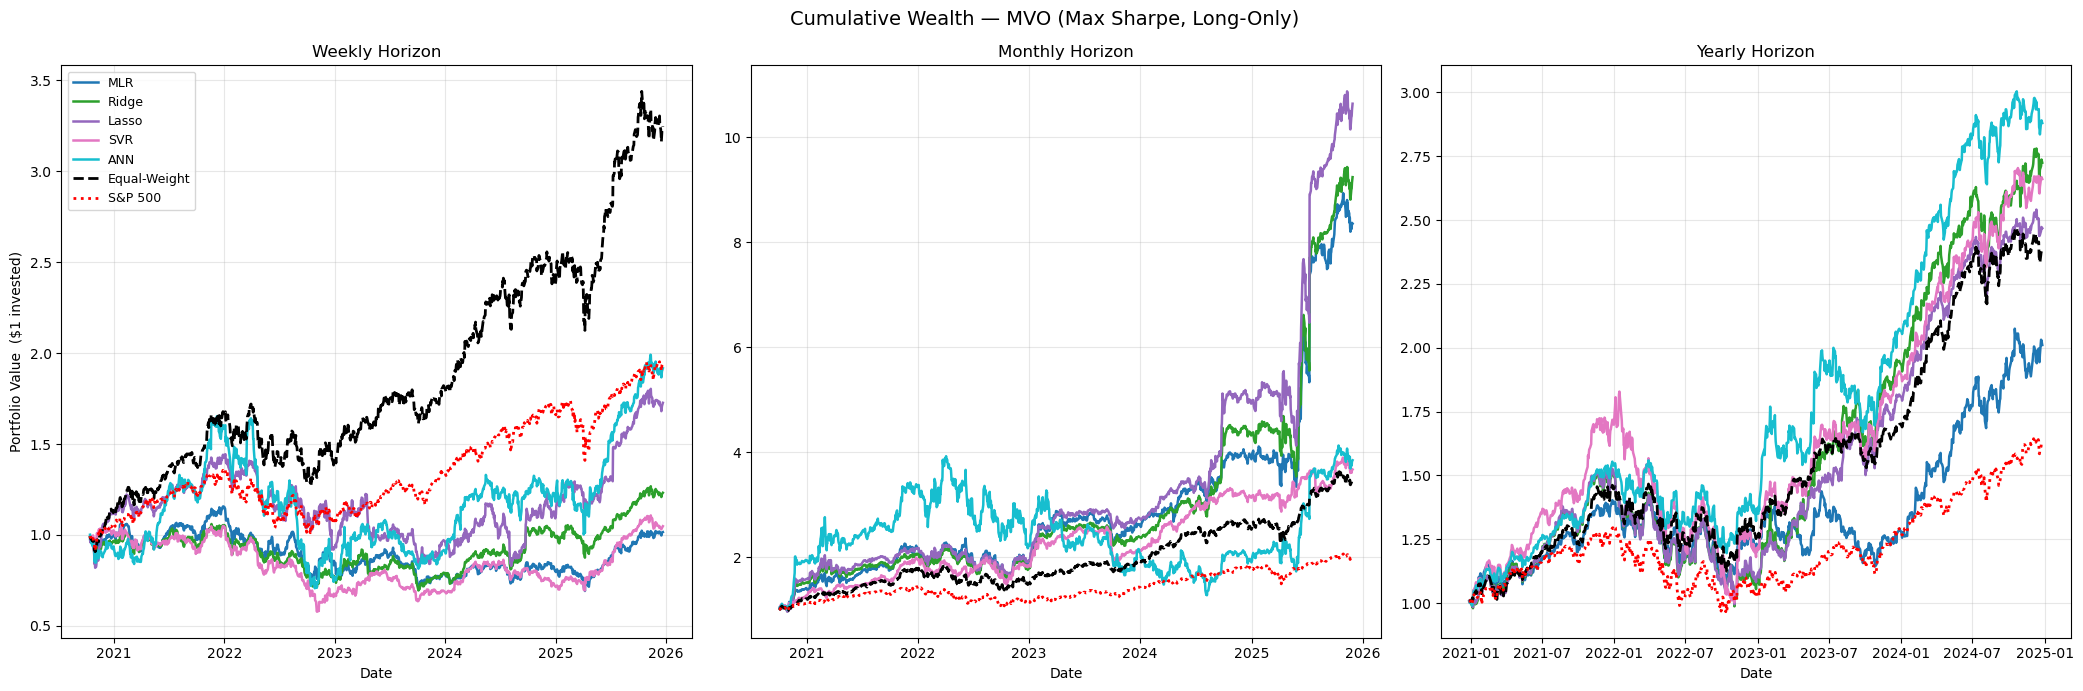

In [55]:

# 11.1  Cumulative Wealth Curves — Weekly / Monthly / Yearly
fig, axes = plt.subplots(1, 3, figsize=(21, 7))
colors = plt.cm.tab10(np.linspace(0, 0.9, len(PORTFOLIO_MODELS)))

for col, horizon in enumerate(HORIZONS):
    ax = axes[col]

    for i, model in enumerate(PORTFOLIO_MODELS):
        key = (model, horizon, "long_only")
        if key in backtest_results:
            cw = backtest_results[key]["cumulative_wealth"]
            ax.plot(cw.index, cw.values, label=model, color=colors[i], linewidth=1.8)

    ew_key = ("Equal-Weight", horizon)
    if ew_key in benchmark_results:
        cw = benchmark_results[ew_key]["cumulative_wealth"]
        ax.plot(cw.index, cw.values, "k--", linewidth=2.0, label="Equal-Weight")

    sp_key = ("S&P 500", horizon)
    if sp_key in benchmark_results:
        cw = benchmark_results[sp_key]["cumulative_wealth"]
        ax.plot(cw.index, cw.values, "r:", linewidth=2.0, label="S&P 500")

    ax.set_title(f"{horizon.capitalize()} Horizon", fontsize=12)
    ax.set_ylabel("Portfolio Value  ($1 invested)" if col == 0 else "")
    ax.set_xlabel("Date")
    ax.grid(True, alpha=0.3)
    if col == 0:
        ax.legend(fontsize=9)

fig.suptitle("Cumulative Wealth — MVO (Max Sharpe, Long-Only)", fontsize=14)
plt.tight_layout()
plt.show()


### 11.2 Drawdown Analysis

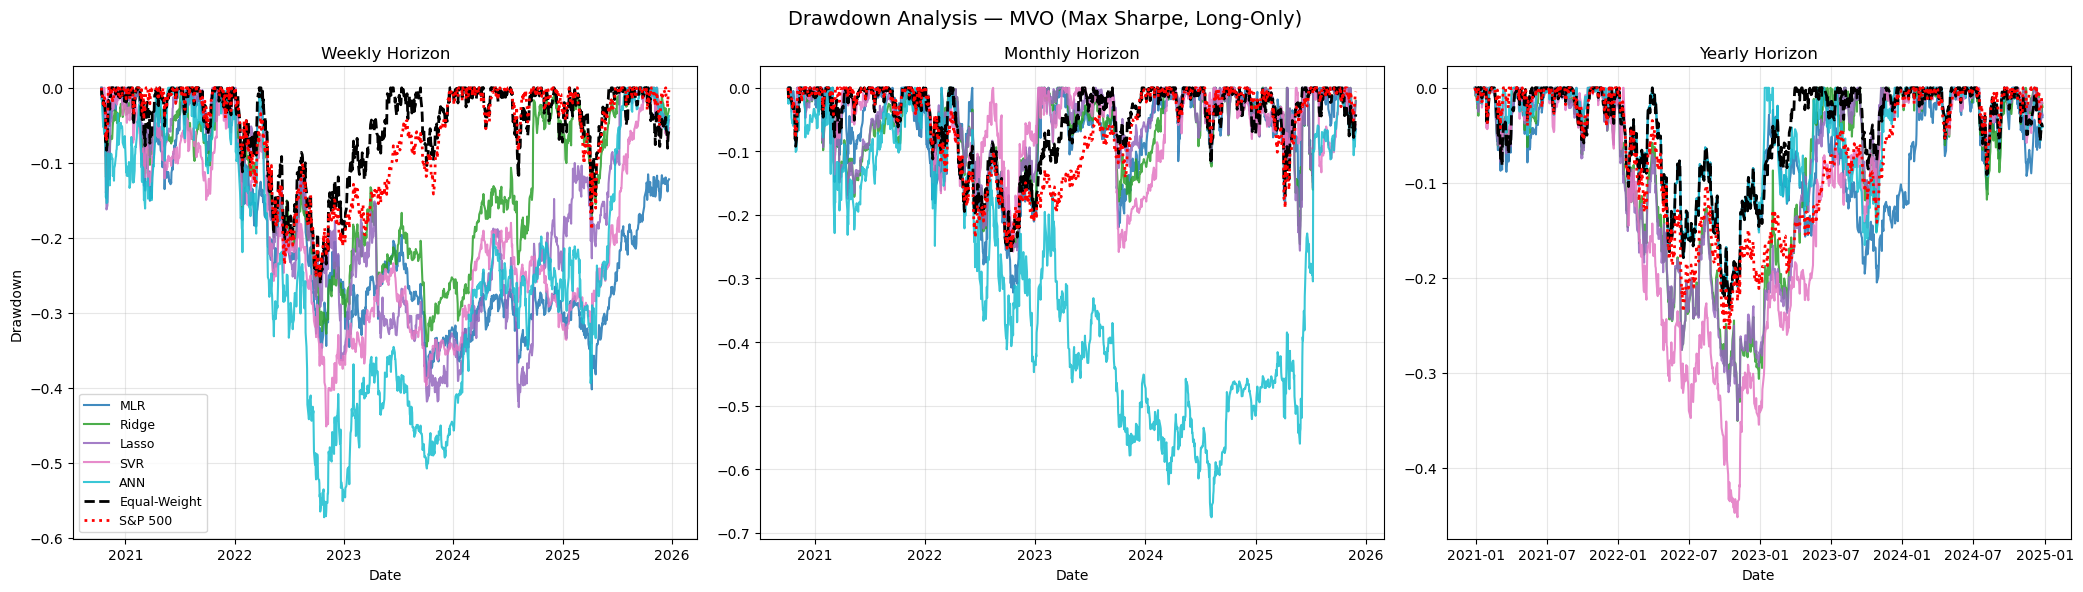

In [56]:

# 11.2  Drawdown Analysis — Weekly / Monthly / Yearly
def compute_drawdown(daily_returns):
    cum = (1 + daily_returns).cumprod()
    return (cum - cum.cummax()) / cum.cummax()

fig, axes = plt.subplots(1, 3, figsize=(21, 6))
colors = plt.cm.tab10(np.linspace(0, 0.9, len(PORTFOLIO_MODELS)))

for col, horizon in enumerate(HORIZONS):
    ax = axes[col]

    for i, model in enumerate(PORTFOLIO_MODELS):
        key = (model, horizon, "long_only")
        if key in backtest_results:
            dd = compute_drawdown(backtest_results[key]["daily_returns"])
            ax.plot(dd.index, dd.values, label=model, color=colors[i], linewidth=1.5, alpha=0.85)

    ew_key = ("Equal-Weight", horizon)
    if ew_key in benchmark_results:
        dd = compute_drawdown(benchmark_results[ew_key]["daily_returns"])
        ax.plot(dd.index, dd.values, "k--", linewidth=2.0, label="Equal-Weight")

    sp_key = ("S&P 500", horizon)
    if sp_key in benchmark_results:
        dd = compute_drawdown(benchmark_results[sp_key]["daily_returns"])
        ax.plot(dd.index, dd.values, "r:", linewidth=2.0, label="S&P 500")

    ax.set_title(f"{horizon.capitalize()} Horizon", fontsize=12)
    ax.set_ylabel("Drawdown" if col == 0 else "")
    ax.set_xlabel("Date")
    ax.grid(True, alpha=0.3)
    if col == 0:
        ax.legend(fontsize=9)

fig.suptitle("Drawdown Analysis — MVO (Max Sharpe, Long-Only)", fontsize=14)
plt.tight_layout()
plt.show()


### 11.3 Weight Allocation Over Time

In [57]:

# 11.3  Weight Allocation Over Time — Weekly / Monthly / Yearly
n_models  = len(PORTFOLIO_MODELS)
fig, axes = plt.subplots(n_models, 3, figsize=(21, 4 * n_models))

for row, model in enumerate(PORTFOLIO_MODELS):
    for col, horizon in enumerate(HORIZONS):
        ax  = axes[row, col]
        key = (model, horizon, "long_only")
        if key not in backtest_results:
            ax.set_visible(False)
            continue
        result = backtest_results[key]
        wh = np.array(result["weights_history"])   # (n_rebalances, n_tickers)
        rd = result["rebalance_dates"][:len(wh)]

        ax.stackplot(rd, wh.T, labels=TICKERS, alpha=0.85)
        ax.set_title(f"{model} — {horizon.capitalize()}", fontsize=10)
        ax.set_ylabel("Weight" if col == 0 else "")
        ax.set_ylim(0, 1)
        ax.grid(True, alpha=0.2)
        if row == 0 and col == 0:
            ax.legend(loc="upper right", fontsize=7, ncol=5)

for ax in axes[-1]:
    ax.set_xlabel("Date")

plt.suptitle("Weight Allocation Over Time — MVO (Max Sharpe, Long-Only)", fontsize=13)
plt.tight_layout()
plt.show()


### 11.4 Sharpe Ratio Comparison

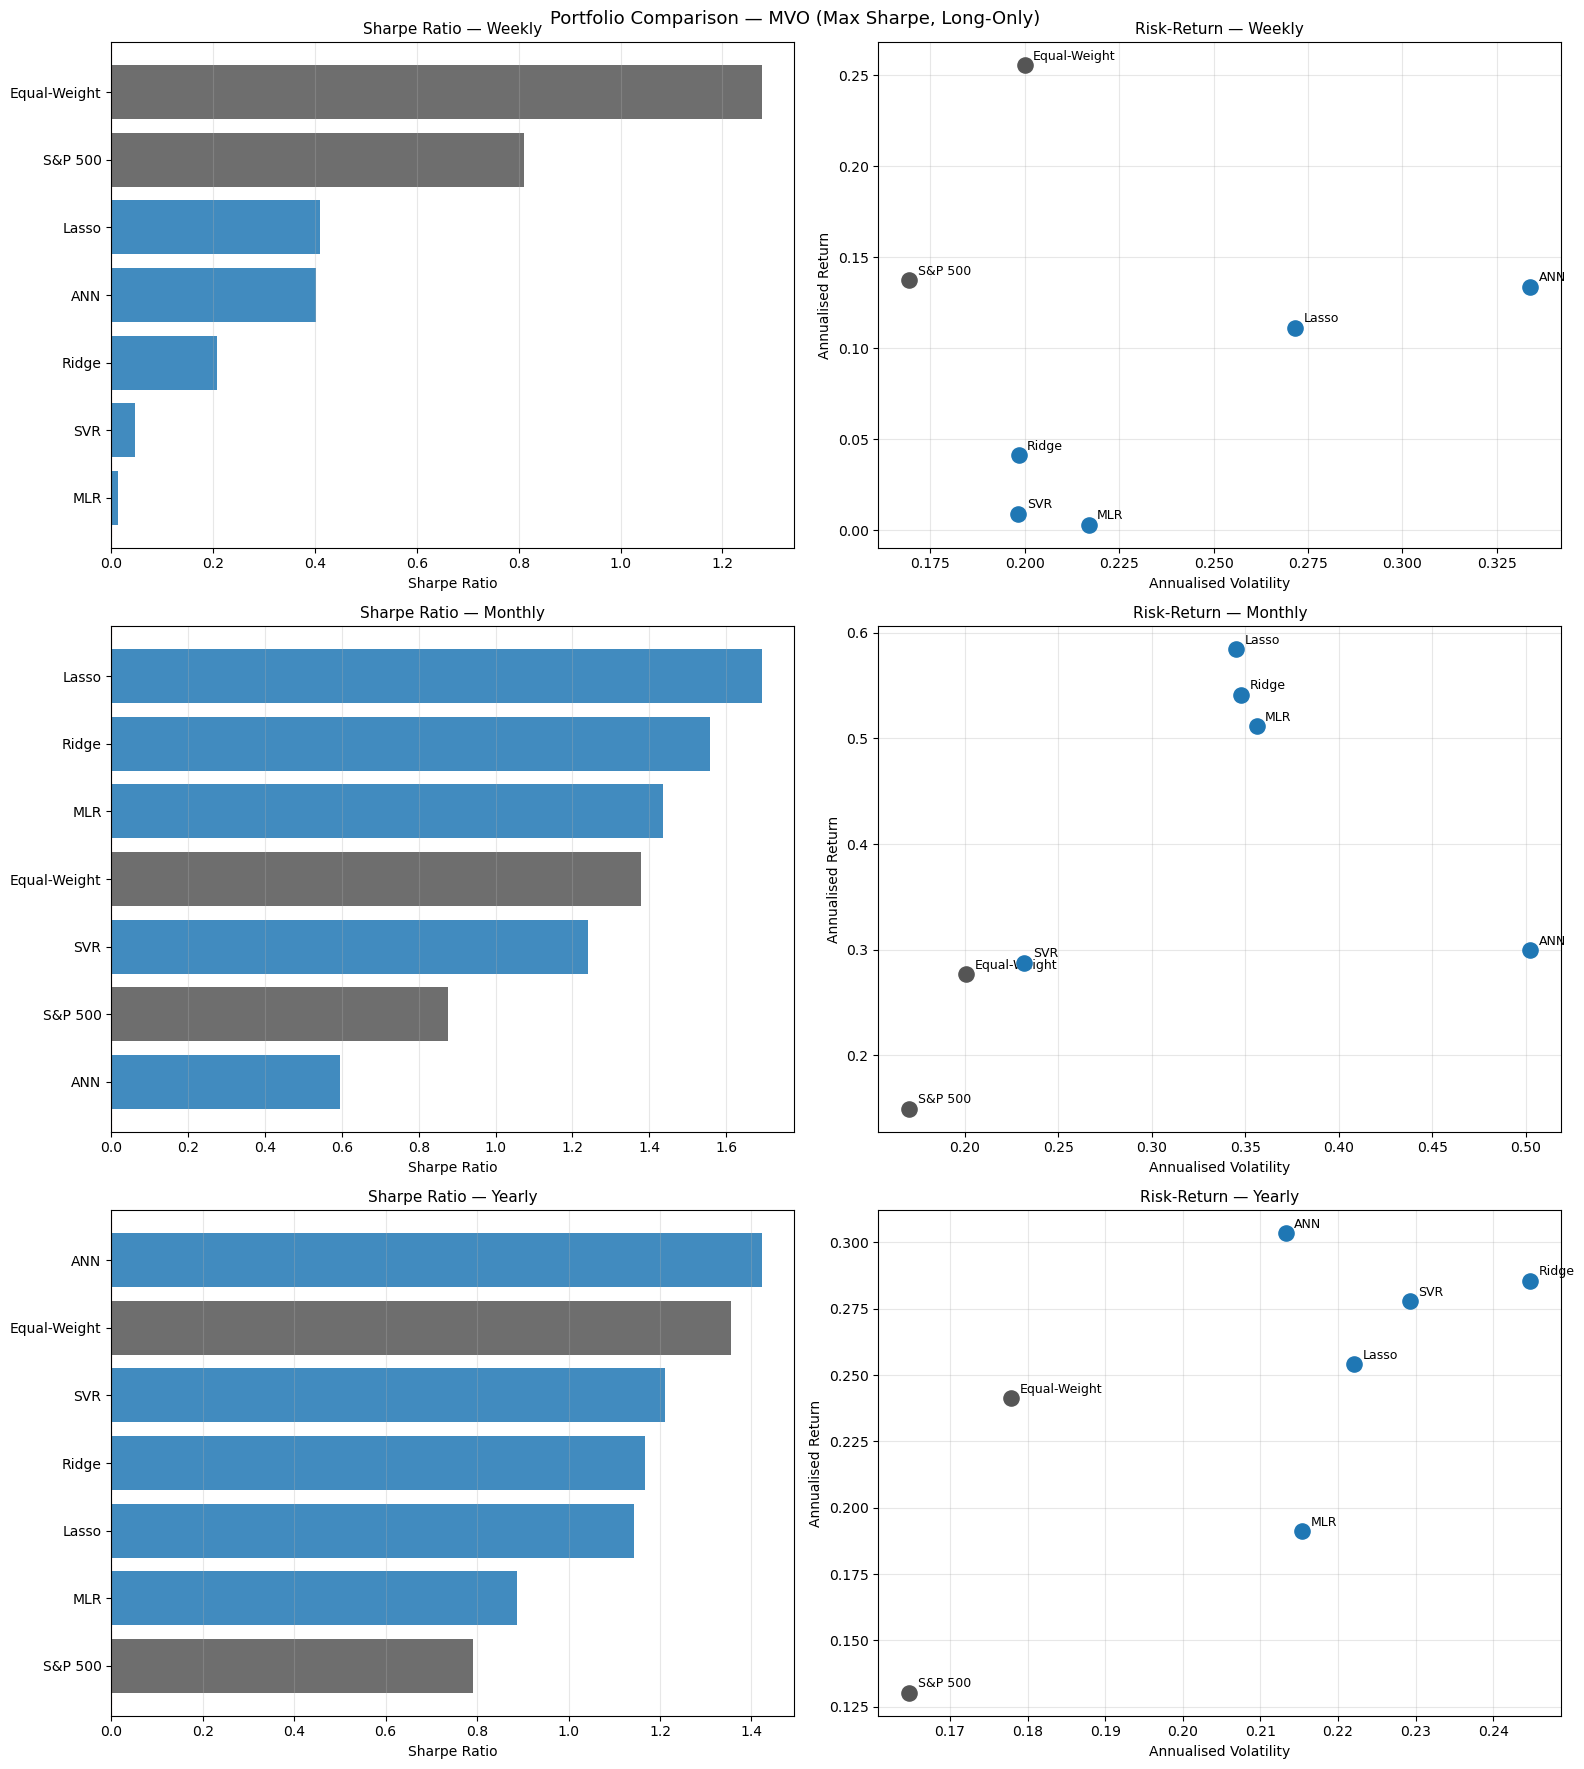

In [59]:

# 11.4  Sharpe & Risk-Return Comparison — Weekly / Monthly / Yearly
fig, axes = plt.subplots(3, 2, figsize=(16, 18))

def _bar_color(model):
    return "#555555" if model in ("Equal-Weight", "S&P 500") else "#1f77b4"

for row, horizon in enumerate(HORIZONS):
    # long_only models + benchmarks only (exclude unconstrained)
    mask = (
        (port_metrics_df["Horizon"] == horizon.capitalize()) &
        (port_metrics_df["Constraint"].isin(["long_only", "benchmark"]))
    )
    subset = port_metrics_df[mask].sort_values("Sharpe Ratio", ascending=True).copy()
    bar_colors = [_bar_color(m) for m in subset["Model"]]

    # Left: Sharpe bar chart
    ax0 = axes[row, 0]
    ax0.barh(subset["Model"], subset["Sharpe Ratio"], color=bar_colors, alpha=0.85)
    ax0.axvline(x=0, color="red", linestyle="--", alpha=0.5)
    ax0.set_xlabel("Sharpe Ratio")
    ax0.set_title(f"Sharpe Ratio — {horizon.capitalize()}", fontsize=11)
    ax0.grid(True, alpha=0.3, axis="x")

    # Right: Risk-Return scatter
    ax1 = axes[row, 1]
    for _, r in subset.iterrows():
        c = _bar_color(r["Model"])
        ax1.scatter(r["Annualised Volatility"], r["Annualised Return"], s=120, color=c, zorder=5)
        ax1.annotate(r["Model"],
                     (r["Annualised Volatility"], r["Annualised Return"]),
                     textcoords="offset points", xytext=(6, 4), fontsize=9)
    ax1.set_xlabel("Annualised Volatility")
    ax1.set_ylabel("Annualised Return")
    ax1.set_title(f"Risk-Return — {horizon.capitalize()}", fontsize=11)
    ax1.grid(True, alpha=0.3)

plt.suptitle("Portfolio Comparison — MVO (Max Sharpe, Long-Only)", fontsize=13)
plt.tight_layout()
plt.show()



### 11.5 Key Findings

**Observations** *(complete after reviewing the results above):*

- **Best model by Sharpe ratio:** *(which model achieved the highest Sharpe?)*
- **vs. Equal-Weight benchmark:** *(do any MVO portfolios beat 1/N?)*
- **Return vs. risk trade-off:** *(does higher return come with higher volatility?)*
- **Max drawdown:** *(which model suffers the deepest drawdown? Does MVO protect against drawdowns vs. equal-weight?)*
- **Portfolio turnover:** *(how frequently do weights shift? Is the strategy practically viable given transaction costs?)*
- **Weight concentration:** *(does MVO over-concentrate in a few tickers, or does the 40% cap force diversification?)*
- **Practical takeaway:** *(which model's predictions are most valuable for portfolio construction?)*


## 12. Sub-Period Stress Analysis

**Goal:** Evaluate how each model portfolio behaves across distinct market regimes within the test window.

> **Note on 2008 & 2020:** Our test period begins **2020-10-13**.  
> - 2008 GFC (Sep 2008 – Mar 2009): entirely in *training* data — not evaluable out-of-sample.  
> - 2020 COVID crash (Feb–Mar 2020): also in *training* data — not evaluable out-of-sample.  
>
> The closest comparable stress event **within our test window** is the **2022 Bear Market** (Jan–Dec 2022), driven by aggressive Fed rate hikes and persistent inflation — S&P 500 fell ~25%.

**Sub-periods analysed:**

| Period | Dates | Market Character |
|---|---|---|
| Full Test | 2020-10-13 → 2025-12-31 | Baseline |
| 2021 Bull Market | 2021-01-01 → 2021-12-31 | Post-COVID recovery rally |
| **2022 Bear Market** | **2022-01-03 → 2022-12-30** | **Fed hikes, inflation shock, tech rout** |
| 2023 Recovery | 2023-01-03 → 2023-12-29 | Soft landing narrative, AI rally begins |
| 2024–2025 Bull Run | 2024-01-02 → 2025-12-31 | AI-driven bull market |

In [ ]:
# ── 12.1  Sub-period metric computation ──────────────────────────────────────

SUB_PERIODS = {
    "Full Test (2020–25)": ("2020-10-13", "2025-12-31"),
    "2021 Bull Market":    ("2021-01-01", "2021-12-31"),
    "2022 Bear Market":    ("2022-01-03", "2022-12-30"),
    "2023 Recovery":       ("2023-01-03", "2023-12-29"),
    "2024–25 Bull Run":    ("2024-01-02", "2025-12-31"),
}

def subperiod_metrics(daily_returns, start, end):
    """Compute annualised return, vol, Sharpe and max drawdown for a date slice."""
    sliced = daily_returns.loc[start:end].dropna()
    if len(sliced) < 10:
        return None
    cumulative  = (1 + sliced).cumprod()
    n_days      = len(sliced)
    total_ret   = cumulative.iloc[-1] - 1
    ann_return  = (1 + total_ret) ** (252 / n_days) - 1
    ann_vol     = sliced.std() * np.sqrt(252)
    sharpe      = (ann_return - RISK_FREE_RATE) / ann_vol if ann_vol > 0 else 0.0
    rolling_max = cumulative.cummax()
    max_dd      = ((cumulative - rolling_max) / rolling_max).min()
    return {
        "Annualised Return":     ann_return,
        "Annualised Volatility": ann_vol,
        "Sharpe Ratio":          sharpe,
        "Max Drawdown":          max_dd,
    }

# Build the sub-period DataFrame
rows = []

for (model_name, horizon, constraint_type), result in backtest_results.items():
    dr = result["daily_returns"]
    for period_name, (start, end) in SUB_PERIODS.items():
        m = subperiod_metrics(dr, start, end)
        if m:
            m.update({"Model": model_name, "Horizon": horizon.capitalize(),
                      "Constraint": constraint_type, "Period": period_name})
            rows.append(m)

for (bench_name, horizon), result in benchmark_results.items():
    dr = result["daily_returns"]
    for period_name, (start, end) in SUB_PERIODS.items():
        m = subperiod_metrics(dr, start, end)
        if m:
            m.update({"Model": bench_name, "Horizon": horizon.capitalize(),
                      "Constraint": "benchmark", "Period": period_name})
            rows.append(m)

subperiod_df = pd.DataFrame(rows)[[
    "Period", "Model", "Horizon", "Constraint",
    "Annualised Return", "Annualised Volatility", "Sharpe Ratio", "Max Drawdown"
]]

print(f"Sub-period table: {len(subperiod_df)} rows\n")

# ── Quick preview: 2022 Bear Market — Monthly, Long-Only ─────────────────────
def show_period(period, horizon="Monthly", constraint="long-only"):
    mask = (
        (subperiod_df["Period"]     == period) &
        (subperiod_df["Horizon"]    == horizon) &
        (subperiod_df["Constraint"].isin([constraint, "benchmark"]))
    )
    df = subperiod_df[mask].copy()
    df = df.sort_values("Sharpe Ratio", ascending=False)
    df["Annualised Return"]     = (df["Annualised Return"]     * 100).round(2).astype(str) + "%"
    df["Annualised Volatility"] = (df["Annualised Volatility"] * 100).round(2).astype(str) + "%"
    df["Sharpe Ratio"]          = df["Sharpe Ratio"].round(3)
    df["Max Drawdown"]          = (df["Max Drawdown"]          * 100).round(2).astype(str) + "%"
    display(df[["Model", "Annualised Return", "Annualised Volatility",
                "Sharpe Ratio", "Max Drawdown"]].reset_index(drop=True))

for period in SUB_PERIODS:
    print(f"\n{'─'*60}")
    print(f"  {period}  |  Monthly  |  Long-Only")
    print(f"{'─'*60}")
    show_period(period)

In [ ]:
# ── 12.2  Visualisations ──────────────────────────────────────────────────────

import matplotlib.dates as mdates
import matplotlib.ticker as mtick

PERIOD_ORDER  = list(SUB_PERIODS.keys())
MODEL_ORDER   = ["MLR", "Ridge", "Lasso", "SVR", "ANN", "Equal-Weight", "S&P 500"]
HORIZON_FOCUS = "Monthly"
CON_FOCUS     = "long-only"

# ── Helper: filter to one horizon/constraint ──────────────────────────────────
def filter_sp(horizon=HORIZON_FOCUS, constraint=CON_FOCUS):
    return subperiod_df[
        (subperiod_df["Horizon"]    == horizon) &
        (subperiod_df["Constraint"].isin([constraint, "benchmark"]))
    ].copy()

sp = filter_sp()

# ══════════════════════════════════════════════════════════════════════════════
# Plot 1 — Sharpe Ratio heatmap across all periods × models
# ══════════════════════════════════════════════════════════════════════════════
pivot_sharpe = (
    sp.pivot_table(index="Model", columns="Period",
                   values="Sharpe Ratio", aggfunc="mean")
      .reindex(index=[m for m in MODEL_ORDER if m in sp["Model"].unique()],
               columns=PERIOD_ORDER)
)

fig, ax = plt.subplots(figsize=(12, 4.5))
im = ax.imshow(pivot_sharpe.values, cmap="RdYlGn", aspect="auto", vmin=-1, vmax=2)
plt.colorbar(im, ax=ax, label="Sharpe Ratio")
ax.set_xticks(range(len(PERIOD_ORDER)))
ax.set_xticklabels(PERIOD_ORDER, rotation=20, ha="right", fontsize=9)
ax.set_yticks(range(len(pivot_sharpe.index)))
ax.set_yticklabels(pivot_sharpe.index, fontsize=10)
for i in range(pivot_sharpe.shape[0]):
    for j in range(pivot_sharpe.shape[1]):
        val = pivot_sharpe.values[i, j]
        if not np.isnan(val):
            ax.text(j, i, f"{val:.2f}", ha="center", va="center",
                    fontsize=9, color="black", fontweight="bold")
ax.set_title(f"Sharpe Ratio by Market Regime — {HORIZON_FOCUS} Horizon, {CON_FOCUS}",
             fontsize=12, fontweight="bold", pad=12)
plt.tight_layout()
plt.show()

# ══════════════════════════════════════════════════════════════════════════════
# Plot 2 — Bar chart: 2022 Bear Market vs Full Test (Sharpe & Max Drawdown)
# ══════════════════════════════════════════════════════════════════════════════
periods_compare = ["Full Test (2020–25)", "2022 Bear Market"]
models_bar = [m for m in MODEL_ORDER if m in sp["Model"].unique()]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
bar_width = 0.35
x = np.arange(len(models_bar))
colors = ["#4C72B0", "#DD8452"]

for ax, metric, ylabel, title_suffix in zip(
        axes,
        ["Sharpe Ratio", "Max Drawdown"],
        ["Sharpe Ratio", "Max Drawdown (%)"],
        ["Sharpe Ratio", "Max Drawdown"]):

    for i, (period, color) in enumerate(zip(periods_compare, colors)):
        vals = []
        for model in models_bar:
            row = sp[(sp["Model"] == model) & (sp["Period"] == period)]
            vals.append(row[metric].values[0] if len(row) else np.nan)

        vals_plot = [v * 100 if metric == "Max Drawdown" else v for v in vals]
        ax.bar(x + i * bar_width, vals_plot, bar_width,
               label=period, color=color, alpha=0.85, edgecolor="white")

    ax.set_xticks(x + bar_width / 2)
    ax.set_xticklabels(models_bar, rotation=25, ha="right", fontsize=9)
    ax.set_ylabel(ylabel)
    ax.set_title(f"{title_suffix} — Full Test vs 2022 Bear Market\n({HORIZON_FOCUS}, {CON_FOCUS})",
                 fontsize=10, fontweight="bold")
    ax.legend(fontsize=9)
    ax.axhline(0, color="black", linewidth=0.8, linestyle="--")
    ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

# ══════════════════════════════════════════════════════════════════════════════
# Plot 3 — Cumulative wealth during 2022 Bear Market (monthly, long-only)
# ══════════════════════════════════════════════════════════════════════════════
bear_start, bear_end = SUB_PERIODS["2022 Bear Market"]
model_colors = plt.cm.tab10(np.linspace(0, 1, len(MODEL_ORDER)))

fig, ax = plt.subplots(figsize=(13, 5))

for (model_name, horizon, constraint_type), result in backtest_results.items():
    if horizon != HORIZON_FOCUS.lower() or constraint_type != CON_FOCUS:
        continue
    dr = result["daily_returns"].loc[bear_start:bear_end].dropna()
    if len(dr) < 5:
        continue
    cw = (1 + dr).cumprod()
    idx = MODEL_ORDER.index(model_name) if model_name in MODEL_ORDER else -1
    color = model_colors[idx] if idx >= 0 else "grey"
    ax.plot(cw.index, cw.values, label=model_name, color=color, linewidth=1.8)

# Benchmarks
for (bench_name, horizon), result in benchmark_results.items():
    if horizon != HORIZON_FOCUS.lower():
        continue
    dr = result["daily_returns"].loc[bear_start:bear_end].dropna()
    if len(dr) < 5:
        continue
    cw = (1 + dr).cumprod()
    ls = "--" if bench_name == "Equal-Weight" else ":"
    ax.plot(cw.index, cw.values, label=bench_name, linestyle=ls,
            color="black" if bench_name == "S&P 500" else "grey",
            linewidth=1.8)

ax.axhline(1, color="black", linewidth=0.7, linestyle="-", alpha=0.4)
ax.set_title("Cumulative Wealth During 2022 Bear Market\n"
             f"({HORIZON_FOCUS} horizon, {CON_FOCUS}) — rebased to 1.0 at Jan 2022",
             fontsize=11, fontweight="bold")
ax.set_ylabel("Portfolio Value (rebased)")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=30, ha="right")
ax.legend(fontsize=9, loc="lower left")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()